# Sentiment Analysis - Natural Language Processing

### Import necessary libraries

In [5]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
import re

import unicodedata
tokenizer = ToktokTokenizer()
#nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

### Reading the Cleaned Dataset

In [6]:
# Read the file
df2 = pd.read_csv('C:/Users/guzel/Documents/amazon_beauty_products/cleaned_dataset.csv')

# Model Performance Improvements

## 1. Adding Most Common and Lest Common Words to Stopwords List

Since there were not too many distinguisher words in different classes, the most and least common 70 words added to the stopwords list and models were applied in order to see any changes in evaluation metrics.

**Words and Frequencies**

In [7]:
cleaned_text = [str(txt) for text in df2['clean_text'] for txt in text.split(' ') 
                if len(txt)>2 and txt not in 'not, nan']

word_dist = nltk.FreqDist(cleaned_text)

**Adding the Most Common and the Least Common 70 Words to the Stopwords List**

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guzel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guzel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
stopword_list= stopwords.words('english')

for y in word_dist.most_common()[-70:]:
    stopword_list.append(y[0])
    
mst_c = word_dist.most_common()[:70]

for x in mst_c:
    stopword_list.append(x[0])

In [10]:
print(len(stopword_list))

319


In [11]:
# Applying the new stopwords List to the Clean Text Column
lemmatizer = WordNetLemmatizer()

df2['clean_text'] = df2['clean_text'].map(lambda text: " ".join([lemmatizer.lemmatize(w) 
                                                               for w in text.split(' ') if w not in stopword_list]))

## Data Preparation

**Separating Response Variable and Feature**

In [12]:
df2['rating_class'] = df2['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [13]:
# Splitting the Data Set into Train and Test Sets
X = df2['clean_text']
y = df2['rating_class']

**Splitting Dataset into Train and Test Set**

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data.

In [14]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Confusion Matrix Plot Function**

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.summer):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [16]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## Modeling (with CountVectorizer)

In [17]:
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

**Creating a function for applying different algorithms**

In [18]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test, ytrain = y_train):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, ytrain)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

### 1.1 Logistic Regression with CountVectorizer

In [19]:
# Call the modeling function for logistic regression with CountVectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.8972954370463345


**Classification Report**

In [20]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.39      0.66      0.49       514
           1       0.97      0.90      0.93      5614

    accuracy                           0.88      6128
   macro avg       0.68      0.78      0.71      6128
weighted avg       0.92      0.88      0.90      6128



**Confusion Matrix**

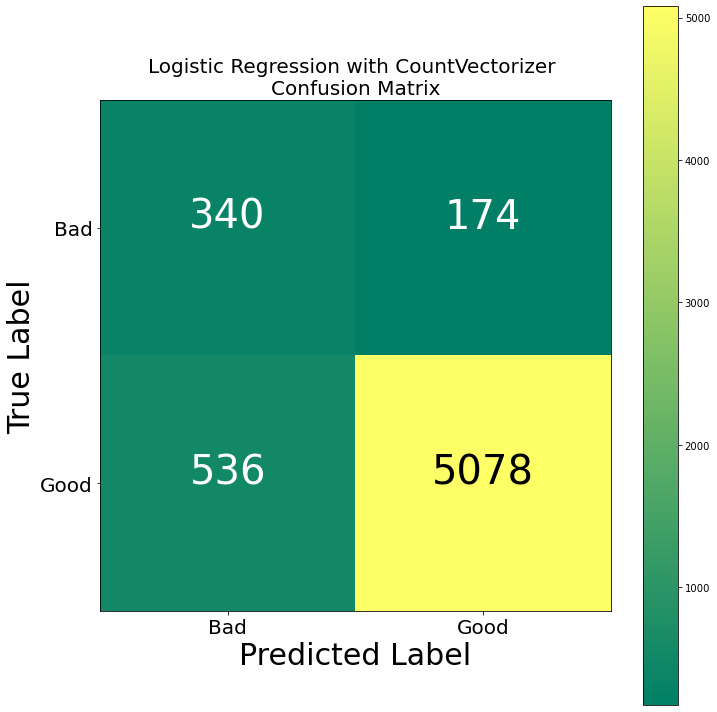

In [21]:
# Print confusion matrix for logistic regression with CountVectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression", "CountVectorizer")

### 1.2 Random Forest with CountVectorizer

In [22]:
# Call the modeling function for random forest classifier with CountVectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.8852710720510772


**Classification Report**

In [23]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.76      0.05      0.09       514
           1       0.92      1.00      0.96      5614

    accuracy                           0.92      6128
   macro avg       0.84      0.52      0.53      6128
weighted avg       0.91      0.92      0.89      6128



**Confusion Matrix**

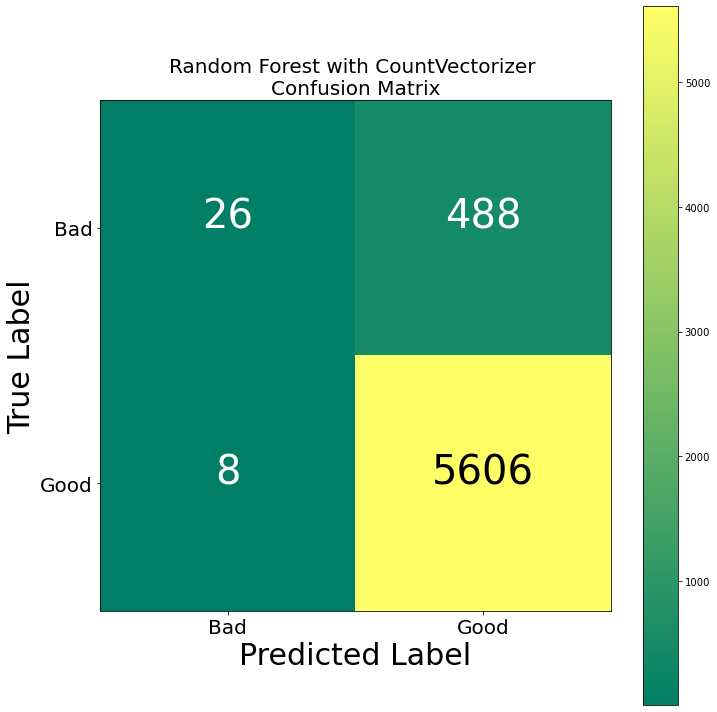

In [24]:
# Print confusion matrix for random forest classifier with CountVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest", "CountVectorizer")

### 1.3 Naive Bayes with CountVectorizer

In [25]:
# Call the modeling function for naive bayes with CountVectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.913422613280677


**Classification Report**

In [26]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.46      0.61      0.53       514
           1       0.96      0.93      0.95      5614

    accuracy                           0.91      6128
   macro avg       0.71      0.77      0.74      6128
weighted avg       0.92      0.91      0.91      6128



**Confusion Matrix**

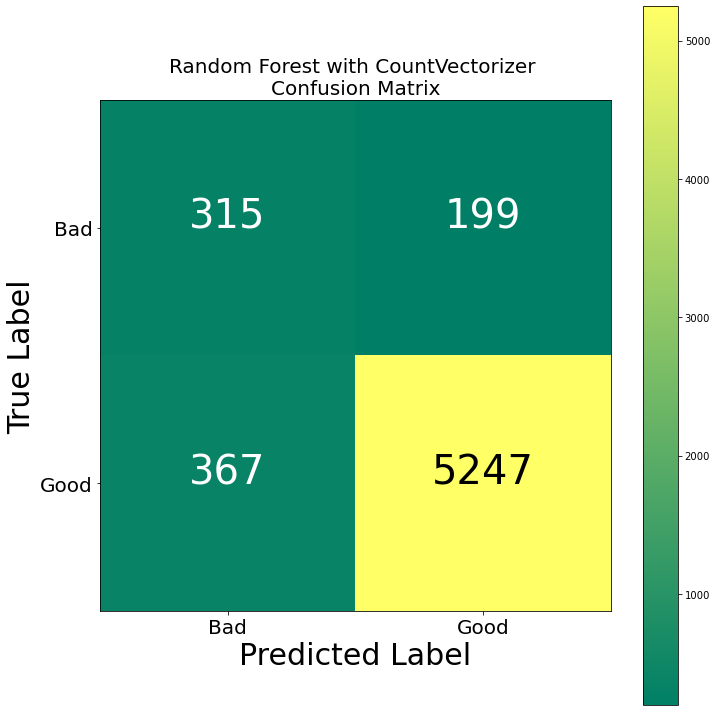

In [27]:
# Print confusion matrix for naive bayes with CountVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Random Forest", "CountVectorizer") 

### 1.4 XGBoost with CountVectorizer

In [28]:
# Call the modeling function for XGBoost with CountVectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.8899492037796051


**Classification Report**

In [29]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.83      0.08      0.14       514
           1       0.92      1.00      0.96      5614

    accuracy                           0.92      6128
   macro avg       0.88      0.54      0.55      6128
weighted avg       0.91      0.92      0.89      6128



**Confusion Matrix**

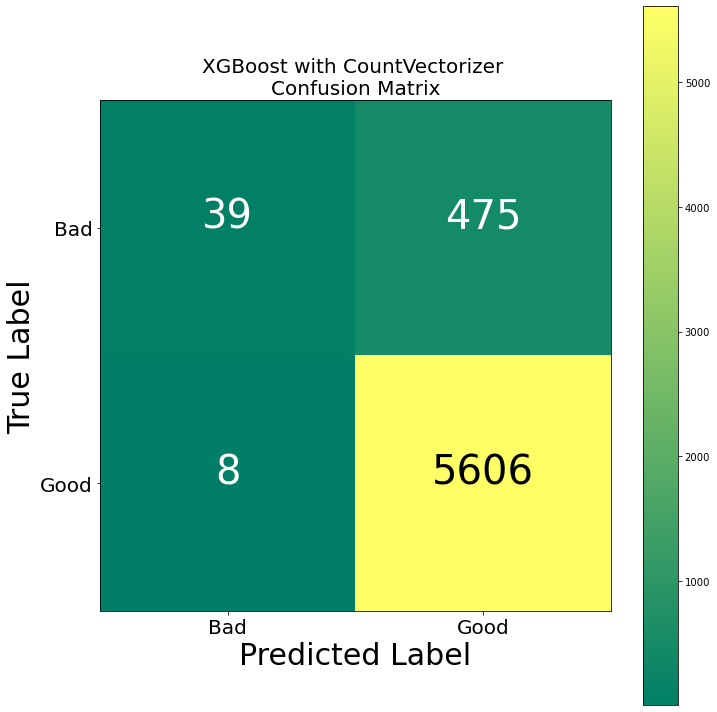

In [30]:
# Print confusion matrix for XGBoost with CountVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost", "CountVectorizer")

### 1.5 Catboosting with CountVectorizer

In [31]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.3017872	total: 151ms	remaining: 3m 45s
1:	learn: 0.2809137	total: 185ms	remaining: 2m 18s
2:	learn: 0.2742690	total: 230ms	remaining: 1m 54s
3:	learn: 0.2693444	total: 272ms	remaining: 1m 41s
4:	learn: 0.2649692	total: 313ms	remaining: 1m 33s
5:	learn: 0.2606847	total: 352ms	remaining: 1m 27s
6:	learn: 0.2579591	total: 391ms	remaining: 1m 23s
7:	learn: 0.2545997	total: 430ms	remaining: 1m 20s
8:	learn: 0.2522409	total: 466ms	remaining: 1m 17s
9:	learn: 0.2491360	total: 506ms	remaining: 1m 15s
10:	learn: 0.2460150	total: 545ms	remaining: 1m 13s
11:	learn: 0.2449698	total: 584ms	remaining: 1m 12s
12:	learn: 0.2429643	total: 619ms	remaining: 1m 10s
13:	learn: 0.2404146	total: 657ms	remaining: 1m 9s
14:	learn: 0.2381606	total: 693ms	remaining: 1m 8s
15:	learn: 0.2362000	total: 734ms	remaining: 1m 8s
16:	learn: 0.2335521	total: 775ms	remaining: 1m 7s
17:	learn: 0.2320075	total: 818ms	remaining: 1m 7s
18:	learn: 0.2306486	total: 857ms	remaining: 1m 6s
19:	learn: 0.2289057	total: 

161:	learn: 0.1623750	total: 6.42s	remaining: 53s
162:	learn: 0.1622870	total: 6.46s	remaining: 53s
163:	learn: 0.1618035	total: 6.49s	remaining: 52.9s
164:	learn: 0.1615920	total: 6.53s	remaining: 52.9s
165:	learn: 0.1612206	total: 6.57s	remaining: 52.8s
166:	learn: 0.1611105	total: 6.61s	remaining: 52.7s
167:	learn: 0.1610164	total: 6.64s	remaining: 52.7s
168:	learn: 0.1604715	total: 6.68s	remaining: 52.6s
169:	learn: 0.1603956	total: 6.72s	remaining: 52.6s
170:	learn: 0.1603284	total: 6.76s	remaining: 52.5s
171:	learn: 0.1602510	total: 6.8s	remaining: 52.5s
172:	learn: 0.1601254	total: 6.83s	remaining: 52.4s
173:	learn: 0.1599226	total: 6.88s	remaining: 52.4s
174:	learn: 0.1598337	total: 6.92s	remaining: 52.4s
175:	learn: 0.1597102	total: 6.95s	remaining: 52.3s
176:	learn: 0.1590612	total: 6.99s	remaining: 52.3s
177:	learn: 0.1590564	total: 7.03s	remaining: 52.2s
178:	learn: 0.1589079	total: 7.07s	remaining: 52.1s
179:	learn: 0.1586322	total: 7.11s	remaining: 52.1s
180:	learn: 0.158

325:	learn: 0.1332019	total: 12.8s	remaining: 46.1s
326:	learn: 0.1331624	total: 12.8s	remaining: 46.1s
327:	learn: 0.1329710	total: 12.9s	remaining: 46s
328:	learn: 0.1329467	total: 12.9s	remaining: 46s
329:	learn: 0.1329118	total: 13s	remaining: 45.9s
330:	learn: 0.1325806	total: 13s	remaining: 45.9s
331:	learn: 0.1325112	total: 13s	remaining: 45.9s
332:	learn: 0.1321394	total: 13.1s	remaining: 45.8s
333:	learn: 0.1321149	total: 13.1s	remaining: 45.8s
334:	learn: 0.1320106	total: 13.1s	remaining: 45.7s
335:	learn: 0.1318775	total: 13.2s	remaining: 45.7s
336:	learn: 0.1316354	total: 13.2s	remaining: 45.6s
337:	learn: 0.1316211	total: 13.3s	remaining: 45.6s
338:	learn: 0.1315772	total: 13.3s	remaining: 45.5s
339:	learn: 0.1315139	total: 13.3s	remaining: 45.5s
340:	learn: 0.1314398	total: 13.4s	remaining: 45.5s
341:	learn: 0.1309972	total: 13.4s	remaining: 45.4s
342:	learn: 0.1309398	total: 13.4s	remaining: 45.4s
343:	learn: 0.1308931	total: 13.5s	remaining: 45.3s
344:	learn: 0.1305804	

484:	learn: 0.1136142	total: 19s	remaining: 39.7s
485:	learn: 0.1134693	total: 19s	remaining: 39.6s
486:	learn: 0.1131747	total: 19s	remaining: 39.6s
487:	learn: 0.1130645	total: 19.1s	remaining: 39.6s
488:	learn: 0.1130528	total: 19.1s	remaining: 39.5s
489:	learn: 0.1128026	total: 19.2s	remaining: 39.5s
490:	learn: 0.1127674	total: 19.2s	remaining: 39.4s
491:	learn: 0.1127079	total: 19.2s	remaining: 39.4s
492:	learn: 0.1125375	total: 19.3s	remaining: 39.3s
493:	learn: 0.1125089	total: 19.3s	remaining: 39.3s
494:	learn: 0.1124535	total: 19.3s	remaining: 39.3s
495:	learn: 0.1124204	total: 19.4s	remaining: 39.2s
496:	learn: 0.1122187	total: 19.4s	remaining: 39.2s
497:	learn: 0.1122052	total: 19.5s	remaining: 39.2s
498:	learn: 0.1120055	total: 19.5s	remaining: 39.1s
499:	learn: 0.1119837	total: 19.5s	remaining: 39.1s
500:	learn: 0.1117634	total: 19.6s	remaining: 39s
501:	learn: 0.1115722	total: 19.6s	remaining: 39s
502:	learn: 0.1115479	total: 19.6s	remaining: 38.9s
503:	learn: 0.1115040	

645:	learn: 0.0986942	total: 25.3s	remaining: 33.5s
646:	learn: 0.0986678	total: 25.4s	remaining: 33.5s
647:	learn: 0.0985094	total: 25.4s	remaining: 33.4s
648:	learn: 0.0985088	total: 25.5s	remaining: 33.4s
649:	learn: 0.0984834	total: 25.5s	remaining: 33.3s
650:	learn: 0.0984309	total: 25.5s	remaining: 33.3s
651:	learn: 0.0983184	total: 25.6s	remaining: 33.3s
652:	learn: 0.0981888	total: 25.6s	remaining: 33.2s
653:	learn: 0.0981309	total: 25.7s	remaining: 33.2s
654:	learn: 0.0979432	total: 25.7s	remaining: 33.1s
655:	learn: 0.0979430	total: 25.7s	remaining: 33.1s
656:	learn: 0.0979188	total: 25.8s	remaining: 33.1s
657:	learn: 0.0979101	total: 25.8s	remaining: 33s
658:	learn: 0.0978148	total: 25.8s	remaining: 33s
659:	learn: 0.0978004	total: 25.9s	remaining: 32.9s
660:	learn: 0.0975765	total: 25.9s	remaining: 32.9s
661:	learn: 0.0975473	total: 26s	remaining: 32.9s
662:	learn: 0.0975175	total: 26s	remaining: 32.8s
663:	learn: 0.0974661	total: 26s	remaining: 32.8s
664:	learn: 0.0973535	

805:	learn: 0.0874048	total: 31.5s	remaining: 27.1s
806:	learn: 0.0871733	total: 31.5s	remaining: 27.1s
807:	learn: 0.0871167	total: 31.6s	remaining: 27s
808:	learn: 0.0870139	total: 31.6s	remaining: 27s
809:	learn: 0.0868957	total: 31.7s	remaining: 27s
810:	learn: 0.0868162	total: 31.7s	remaining: 26.9s
811:	learn: 0.0867970	total: 31.7s	remaining: 26.9s
812:	learn: 0.0867849	total: 31.8s	remaining: 26.8s
813:	learn: 0.0866783	total: 31.8s	remaining: 26.8s
814:	learn: 0.0866758	total: 31.8s	remaining: 26.8s
815:	learn: 0.0866360	total: 31.9s	remaining: 26.7s
816:	learn: 0.0863908	total: 31.9s	remaining: 26.7s
817:	learn: 0.0863703	total: 32s	remaining: 26.6s
818:	learn: 0.0862274	total: 32s	remaining: 26.6s
819:	learn: 0.0862095	total: 32s	remaining: 26.6s
820:	learn: 0.0861039	total: 32.1s	remaining: 26.5s
821:	learn: 0.0860354	total: 32.1s	remaining: 26.5s
822:	learn: 0.0860227	total: 32.1s	remaining: 26.4s
823:	learn: 0.0859035	total: 32.2s	remaining: 26.4s
824:	learn: 0.0859007	to

966:	learn: 0.0785710	total: 37.6s	remaining: 20.7s
967:	learn: 0.0785536	total: 37.6s	remaining: 20.7s
968:	learn: 0.0783679	total: 37.7s	remaining: 20.7s
969:	learn: 0.0783653	total: 37.7s	remaining: 20.6s
970:	learn: 0.0783551	total: 37.8s	remaining: 20.6s
971:	learn: 0.0783498	total: 37.8s	remaining: 20.5s
972:	learn: 0.0781798	total: 37.8s	remaining: 20.5s
973:	learn: 0.0781627	total: 37.9s	remaining: 20.5s
974:	learn: 0.0781289	total: 37.9s	remaining: 20.4s
975:	learn: 0.0780851	total: 37.9s	remaining: 20.4s
976:	learn: 0.0780563	total: 38s	remaining: 20.3s
977:	learn: 0.0780547	total: 38s	remaining: 20.3s
978:	learn: 0.0780229	total: 38.1s	remaining: 20.3s
979:	learn: 0.0779649	total: 38.1s	remaining: 20.2s
980:	learn: 0.0779161	total: 38.1s	remaining: 20.2s
981:	learn: 0.0778016	total: 38.2s	remaining: 20.1s
982:	learn: 0.0777825	total: 38.2s	remaining: 20.1s
983:	learn: 0.0777639	total: 38.2s	remaining: 20.1s
984:	learn: 0.0777519	total: 38.3s	remaining: 20s
985:	learn: 0.0775

1123:	learn: 0.0713066	total: 43.7s	remaining: 14.6s
1124:	learn: 0.0713066	total: 43.7s	remaining: 14.6s
1125:	learn: 0.0712087	total: 43.7s	remaining: 14.5s
1126:	learn: 0.0710799	total: 43.8s	remaining: 14.5s
1127:	learn: 0.0710289	total: 43.8s	remaining: 14.4s
1128:	learn: 0.0710279	total: 43.9s	remaining: 14.4s
1129:	learn: 0.0709460	total: 43.9s	remaining: 14.4s
1130:	learn: 0.0709305	total: 43.9s	remaining: 14.3s
1131:	learn: 0.0709299	total: 44s	remaining: 14.3s
1132:	learn: 0.0709269	total: 44s	remaining: 14.3s
1133:	learn: 0.0709136	total: 44s	remaining: 14.2s
1134:	learn: 0.0709012	total: 44.1s	remaining: 14.2s
1135:	learn: 0.0708695	total: 44.1s	remaining: 14.1s
1136:	learn: 0.0708562	total: 44.2s	remaining: 14.1s
1137:	learn: 0.0708024	total: 44.2s	remaining: 14.1s
1138:	learn: 0.0707404	total: 44.2s	remaining: 14s
1139:	learn: 0.0707288	total: 44.3s	remaining: 14s
1140:	learn: 0.0707253	total: 44.3s	remaining: 13.9s
1141:	learn: 0.0707127	total: 44.3s	remaining: 13.9s
114

1282:	learn: 0.0656387	total: 49.6s	remaining: 8.39s
1283:	learn: 0.0656360	total: 49.6s	remaining: 8.35s
1284:	learn: 0.0656356	total: 49.7s	remaining: 8.31s
1285:	learn: 0.0656319	total: 49.7s	remaining: 8.27s
1286:	learn: 0.0655676	total: 49.7s	remaining: 8.23s
1287:	learn: 0.0655676	total: 49.8s	remaining: 8.19s
1288:	learn: 0.0654705	total: 49.8s	remaining: 8.15s
1289:	learn: 0.0654579	total: 49.9s	remaining: 8.12s
1290:	learn: 0.0654568	total: 49.9s	remaining: 8.08s
1291:	learn: 0.0654556	total: 49.9s	remaining: 8.04s
1292:	learn: 0.0653801	total: 50s	remaining: 8s
1293:	learn: 0.0653591	total: 50s	remaining: 7.96s
1294:	learn: 0.0652504	total: 50s	remaining: 7.92s
1295:	learn: 0.0651846	total: 50.1s	remaining: 7.88s
1296:	learn: 0.0651426	total: 50.1s	remaining: 7.84s
1297:	learn: 0.0651410	total: 50.1s	remaining: 7.8s
1298:	learn: 0.0651264	total: 50.2s	remaining: 7.76s
1299:	learn: 0.0651041	total: 50.2s	remaining: 7.73s
1300:	learn: 0.0650942	total: 50.3s	remaining: 7.69s
130

1439:	learn: 0.0603745	total: 55.5s	remaining: 2.31s
1440:	learn: 0.0602836	total: 55.6s	remaining: 2.27s
1441:	learn: 0.0602832	total: 55.6s	remaining: 2.24s
1442:	learn: 0.0602740	total: 55.6s	remaining: 2.2s
1443:	learn: 0.0602290	total: 55.7s	remaining: 2.16s
1444:	learn: 0.0602071	total: 55.7s	remaining: 2.12s
1445:	learn: 0.0602067	total: 55.8s	remaining: 2.08s
1446:	learn: 0.0601994	total: 55.8s	remaining: 2.04s
1447:	learn: 0.0601116	total: 55.9s	remaining: 2s
1448:	learn: 0.0600348	total: 55.9s	remaining: 1.97s
1449:	learn: 0.0600348	total: 55.9s	remaining: 1.93s
1450:	learn: 0.0599953	total: 56s	remaining: 1.89s
1451:	learn: 0.0599881	total: 56s	remaining: 1.85s
1452:	learn: 0.0599880	total: 56.1s	remaining: 1.81s
1453:	learn: 0.0599489	total: 56.1s	remaining: 1.77s
1454:	learn: 0.0599479	total: 56.1s	remaining: 1.74s
1455:	learn: 0.0599409	total: 56.2s	remaining: 1.7s
1456:	learn: 0.0599336	total: 56.2s	remaining: 1.66s
1457:	learn: 0.0599320	total: 56.2s	remaining: 1.62s
14

**Classification Report**

In [32]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.64      0.37      0.46       514
           1       0.94      0.98      0.96      5614

    accuracy                           0.93      6128
   macro avg       0.79      0.67      0.71      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

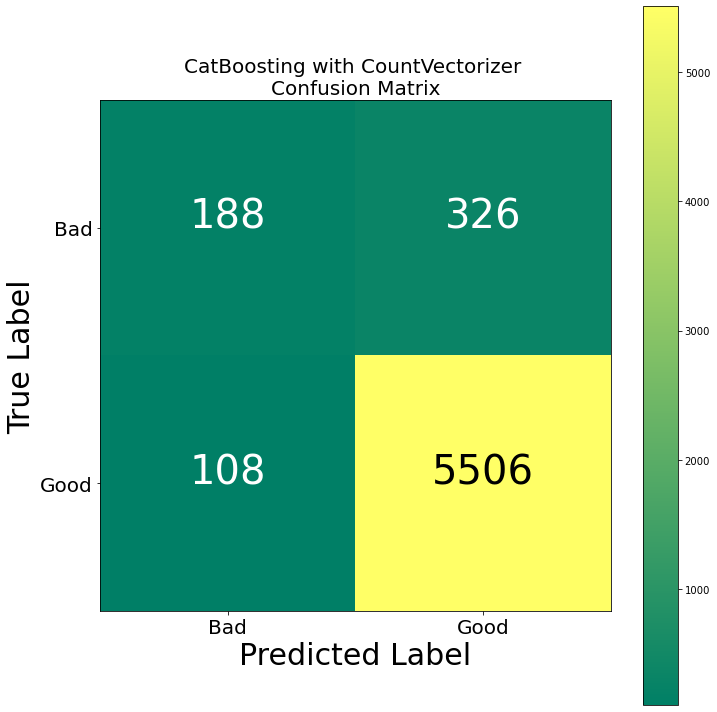

In [33]:
# Print confusion matrix for CatBoost with CountVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting", "CountVectorizer")

### 1.6 Comparision of Models 

**Functions for Algorithms Comparison**

In [34]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
global comparison_matrix
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [35]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

**Function for f1 score plotting**

In [36]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

**Model Comparison Table**

In [37]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [38]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with Expanded Stopword List\n')
df_tv2


Comparision Matrix of Modeling with Expanded Stopword List



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.884138 bad       0.388128  0.661479  0.489209   
                                  good      0.966870  0.904524  0.934659   
                                  average   0.918326  0.884138  0.897295   
           Random Forest 0.919060 bad       0.764706  0.050584  0.094891   
                                  good      0.919921  0.998575  0.957636   
                                  average   0.906902  0.919060  0.885271   
           Naive Bayes   0.907637 bad       0.461877  0.612840  0.526756   
                                  good      0.963459  0.934628  0.948825   
                                  average   0.921388  0.907637  0.913423   
           XGBoost       0.921181 bad       0.829787  0.075875  0.139037   
                                  good      0.921888  0.998575  0.958700   
                                  average   0.914163  0.921181  0.889949   
           CatBoost      0.929178 bad       0.635135  0.365759  0.464198   
                                  good      0.944102  0.980762  0.962083   
                                  average   0.918186  0.929178  0.920322   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.884138 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.919060 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.907637 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.921181 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.929178 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 scores**

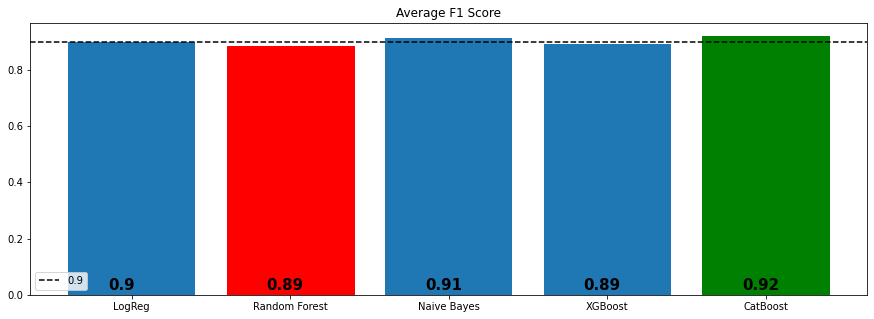

In [39]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

# 2. Synthetic Minority Oversampling Technique (SMOTE)

In [40]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
df_text, df_target = sm.fit_sample(count_vect_train, y_train)
print (df_text.shape)
print (df_target.shape)

(33622, 3274)
(33622,)


In [41]:
from collections import Counter
Counter(df_target)

Counter({1: 16811, 0: 16811})

### 2.1 Logistic Regression

In [42]:
# Call the modeling function for logistic regression and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, 
                            random_state = 42), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_logreg = y_pred

f1 score: 0.87480746097881


**Classification Report**

In [43]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_logreg))

              precision    recall  f1-score   support

           0       0.30      0.52      0.38       514
           1       0.95      0.89      0.92      5614

    accuracy                           0.86      6128
   macro avg       0.63      0.70      0.65      6128
weighted avg       0.90      0.86      0.87      6128



**Confusion Matrix**

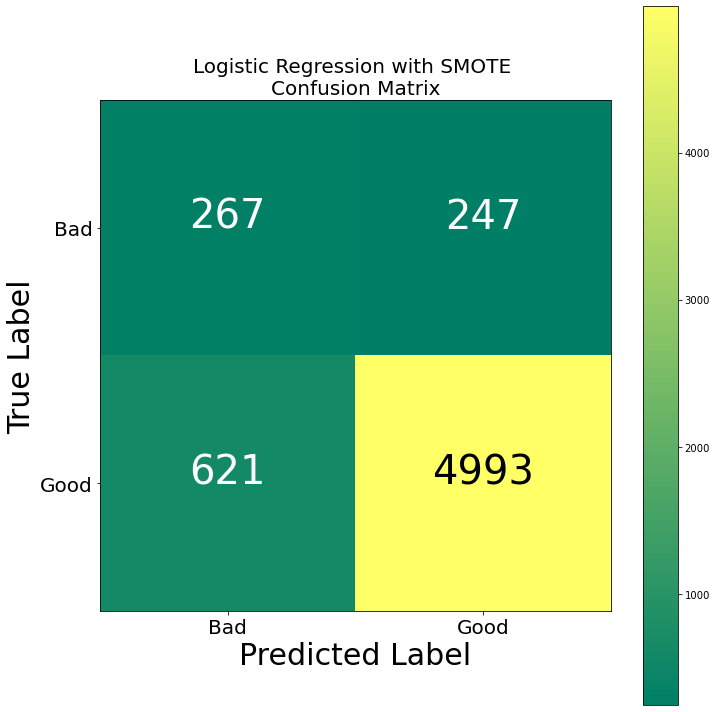

In [44]:
# Print confusion matrix for logistic regression 
disp_confusion_matrix(y_pred_sm_logreg, "Logistic Regression", "SMOTE")

### 2.2 Random Forest

In [45]:
# Call the modeling function for random forest classifier and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_rf = y_pred

f1 score: 0.8719839102263005


**Classification Report**

In [46]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_rf))

              precision    recall  f1-score   support

           0       0.21      0.15      0.17       514
           1       0.92      0.95      0.94      5614

    accuracy                           0.88      6128
   macro avg       0.57      0.55      0.55      6128
weighted avg       0.86      0.88      0.87      6128



**Confusion Matrix**

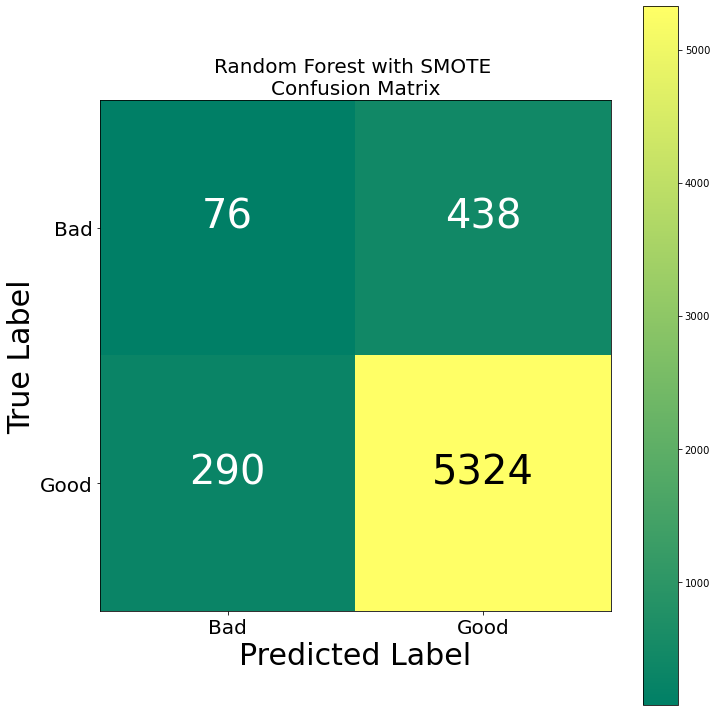

In [47]:
# Print confusion matrix for random forest classifier
disp_confusion_matrix(y_pred_sm_rf, "Random Forest", "SMOTE")

### 2.3 Naive Bayes

In [48]:
# Call the modeling function for naive bayes and print f1 score
modeling(MultinomialNB(), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_nb = y_pred

f1 score: 0.8957669283502686


**Classification Report**

In [49]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_nb))

              precision    recall  f1-score   support

           0       0.38      0.57      0.46       514
           1       0.96      0.91      0.94      5614

    accuracy                           0.89      6128
   macro avg       0.67      0.74      0.70      6128
weighted avg       0.91      0.89      0.90      6128



**Confusion Matrix**

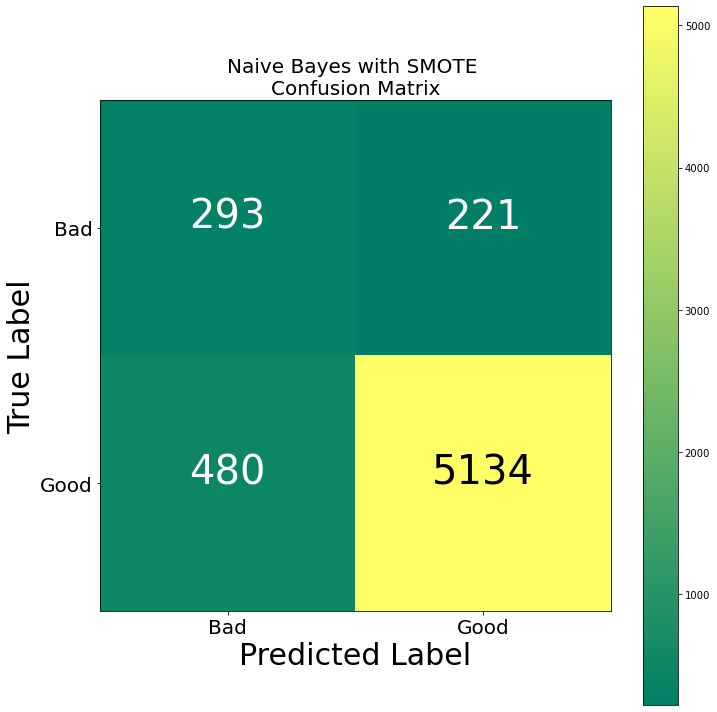

In [50]:
# Print confusion matrix for naive bayes
disp_confusion_matrix(y_pred_sm_nb, "Naive Bayes", "SMOTE")

### 2.4 XGBoost 

In [51]:
# Call the modeling function for XGBoost and print f1 score
modeling(XGBClassifier(), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_xgb = y_pred

f1 score: 0.7903191464627287


**Classification Report**

In [52]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_xgb))

              precision    recall  f1-score   support

           0       0.14      0.43      0.22       514
           1       0.94      0.77      0.84      5614

    accuracy                           0.74      6128
   macro avg       0.54      0.60      0.53      6128
weighted avg       0.87      0.74      0.79      6128



**Confusion Matrix**

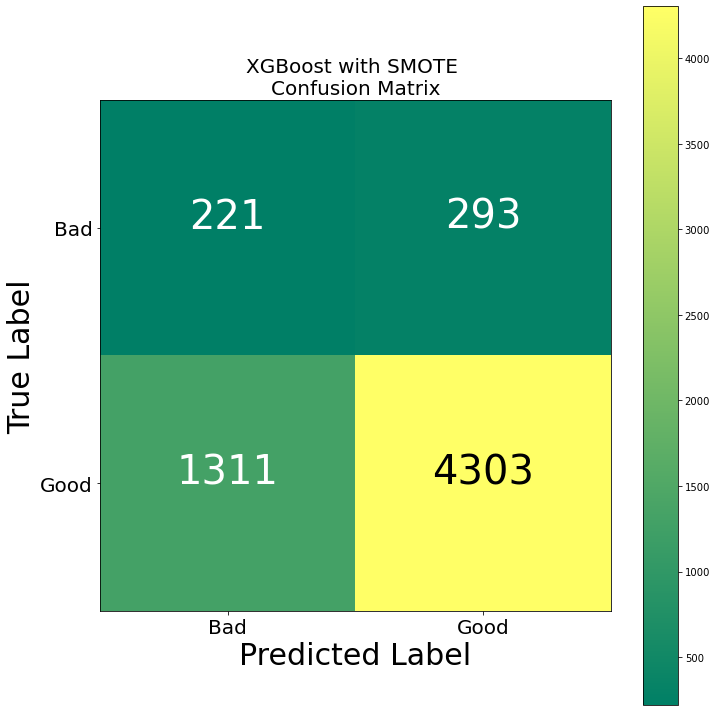

In [53]:
# Print confusion matrix for XGBoost
disp_confusion_matrix(y_pred_sm_xgb, "XGBoost", "SMOTE")

### 2.5 CatBoost 

In [54]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_catboost = y_pred

0:	learn: 0.6414937	total: 28.1ms	remaining: 42.1s
1:	learn: 0.6026391	total: 50.5ms	remaining: 37.8s
2:	learn: 0.5772381	total: 74.4ms	remaining: 37.1s
3:	learn: 0.5501180	total: 99.3ms	remaining: 37.1s
4:	learn: 0.5248748	total: 124ms	remaining: 37s
5:	learn: 0.5029888	total: 147ms	remaining: 36.7s
6:	learn: 0.4856987	total: 174ms	remaining: 37s
7:	learn: 0.4720978	total: 199ms	remaining: 37.1s
8:	learn: 0.4569267	total: 222ms	remaining: 36.8s
9:	learn: 0.4457467	total: 252ms	remaining: 37.5s
10:	learn: 0.4375347	total: 278ms	remaining: 37.7s
11:	learn: 0.4286963	total: 302ms	remaining: 37.4s
12:	learn: 0.4210118	total: 326ms	remaining: 37.2s
13:	learn: 0.4139341	total: 348ms	remaining: 37s
14:	learn: 0.4081587	total: 370ms	remaining: 36.6s
15:	learn: 0.4009714	total: 392ms	remaining: 36.4s
16:	learn: 0.3953967	total: 418ms	remaining: 36.5s
17:	learn: 0.3896385	total: 442ms	remaining: 36.4s
18:	learn: 0.3845976	total: 471ms	remaining: 36.7s
19:	learn: 0.3796495	total: 499ms	remaining

167:	learn: 0.2127610	total: 4.39s	remaining: 34.8s
168:	learn: 0.2125896	total: 4.42s	remaining: 34.8s
169:	learn: 0.2120815	total: 4.45s	remaining: 34.8s
170:	learn: 0.2116602	total: 4.48s	remaining: 34.8s
171:	learn: 0.2112546	total: 4.51s	remaining: 34.8s
172:	learn: 0.2109185	total: 4.54s	remaining: 34.8s
173:	learn: 0.2103477	total: 4.57s	remaining: 34.8s
174:	learn: 0.2098375	total: 4.59s	remaining: 34.8s
175:	learn: 0.2095898	total: 4.62s	remaining: 34.8s
176:	learn: 0.2092136	total: 4.65s	remaining: 34.7s
177:	learn: 0.2086988	total: 4.68s	remaining: 34.8s
178:	learn: 0.2082190	total: 4.71s	remaining: 34.8s
179:	learn: 0.2079305	total: 4.74s	remaining: 34.8s
180:	learn: 0.2076796	total: 4.77s	remaining: 34.8s
181:	learn: 0.2075234	total: 4.8s	remaining: 34.8s
182:	learn: 0.2073742	total: 4.83s	remaining: 34.7s
183:	learn: 0.2072590	total: 4.85s	remaining: 34.7s
184:	learn: 0.2069524	total: 4.88s	remaining: 34.7s
185:	learn: 0.2068672	total: 4.9s	remaining: 34.6s
186:	learn: 0.

329:	learn: 0.1746564	total: 8.83s	remaining: 31.3s
330:	learn: 0.1744522	total: 8.86s	remaining: 31.3s
331:	learn: 0.1743917	total: 8.89s	remaining: 31.3s
332:	learn: 0.1743397	total: 8.92s	remaining: 31.3s
333:	learn: 0.1741586	total: 8.94s	remaining: 31.2s
334:	learn: 0.1738395	total: 8.97s	remaining: 31.2s
335:	learn: 0.1734832	total: 9s	remaining: 31.2s
336:	learn: 0.1734535	total: 9.03s	remaining: 31.2s
337:	learn: 0.1733969	total: 9.06s	remaining: 31.1s
338:	learn: 0.1729506	total: 9.09s	remaining: 31.1s
339:	learn: 0.1725155	total: 9.12s	remaining: 31.1s
340:	learn: 0.1724528	total: 9.14s	remaining: 31.1s
341:	learn: 0.1724158	total: 9.17s	remaining: 31.1s
342:	learn: 0.1723588	total: 9.2s	remaining: 31s
343:	learn: 0.1721208	total: 9.24s	remaining: 31.1s
344:	learn: 0.1720648	total: 9.27s	remaining: 31s
345:	learn: 0.1718381	total: 9.29s	remaining: 31s
346:	learn: 0.1717462	total: 9.32s	remaining: 31s
347:	learn: 0.1717206	total: 9.34s	remaining: 30.9s
348:	learn: 0.1716482	to

494:	learn: 0.1507367	total: 13.4s	remaining: 27.3s
495:	learn: 0.1506011	total: 13.5s	remaining: 27.3s
496:	learn: 0.1504051	total: 13.5s	remaining: 27.2s
497:	learn: 0.1501337	total: 13.5s	remaining: 27.2s
498:	learn: 0.1499162	total: 13.5s	remaining: 27.2s
499:	learn: 0.1498833	total: 13.6s	remaining: 27.1s
500:	learn: 0.1496848	total: 13.6s	remaining: 27.1s
501:	learn: 0.1496743	total: 13.6s	remaining: 27.1s
502:	learn: 0.1496458	total: 13.6s	remaining: 27s
503:	learn: 0.1495719	total: 13.7s	remaining: 27s
504:	learn: 0.1495542	total: 13.7s	remaining: 27s
505:	learn: 0.1493323	total: 13.7s	remaining: 27s
506:	learn: 0.1491272	total: 13.8s	remaining: 26.9s
507:	learn: 0.1489736	total: 13.8s	remaining: 26.9s
508:	learn: 0.1489598	total: 13.8s	remaining: 26.9s
509:	learn: 0.1488309	total: 13.8s	remaining: 26.9s
510:	learn: 0.1487684	total: 13.9s	remaining: 26.9s
511:	learn: 0.1484792	total: 13.9s	remaining: 26.8s
512:	learn: 0.1483522	total: 13.9s	remaining: 26.8s
513:	learn: 0.148352

656:	learn: 0.1330448	total: 17.7s	remaining: 22.8s
657:	learn: 0.1330327	total: 17.8s	remaining: 22.7s
658:	learn: 0.1329690	total: 17.8s	remaining: 22.7s
659:	learn: 0.1327827	total: 17.8s	remaining: 22.7s
660:	learn: 0.1327592	total: 17.8s	remaining: 22.6s
661:	learn: 0.1326417	total: 17.9s	remaining: 22.6s
662:	learn: 0.1325456	total: 17.9s	remaining: 22.6s
663:	learn: 0.1324113	total: 17.9s	remaining: 22.5s
664:	learn: 0.1323882	total: 17.9s	remaining: 22.5s
665:	learn: 0.1323627	total: 18s	remaining: 22.5s
666:	learn: 0.1322391	total: 18s	remaining: 22.4s
667:	learn: 0.1320707	total: 18s	remaining: 22.4s
668:	learn: 0.1320285	total: 18s	remaining: 22.4s
669:	learn: 0.1318496	total: 18s	remaining: 22.4s
670:	learn: 0.1317462	total: 18.1s	remaining: 22.3s
671:	learn: 0.1317349	total: 18.1s	remaining: 22.3s
672:	learn: 0.1317125	total: 18.1s	remaining: 22.3s
673:	learn: 0.1315659	total: 18.1s	remaining: 22.2s
674:	learn: 0.1314997	total: 18.2s	remaining: 22.2s
675:	learn: 0.1314299	

820:	learn: 0.1205031	total: 22s	remaining: 18.2s
821:	learn: 0.1204325	total: 22.1s	remaining: 18.2s
822:	learn: 0.1204143	total: 22.1s	remaining: 18.2s
823:	learn: 0.1203182	total: 22.1s	remaining: 18.1s
824:	learn: 0.1201242	total: 22.2s	remaining: 18.1s
825:	learn: 0.1200660	total: 22.2s	remaining: 18.1s
826:	learn: 0.1199293	total: 22.2s	remaining: 18.1s
827:	learn: 0.1199241	total: 22.2s	remaining: 18.1s
828:	learn: 0.1198235	total: 22.3s	remaining: 18s
829:	learn: 0.1198225	total: 22.3s	remaining: 18s
830:	learn: 0.1198059	total: 22.4s	remaining: 18s
831:	learn: 0.1196714	total: 22.4s	remaining: 18s
832:	learn: 0.1196341	total: 22.4s	remaining: 17.9s
833:	learn: 0.1194614	total: 22.4s	remaining: 17.9s
834:	learn: 0.1194540	total: 22.5s	remaining: 17.9s
835:	learn: 0.1194381	total: 22.5s	remaining: 17.9s
836:	learn: 0.1193554	total: 22.5s	remaining: 17.8s
837:	learn: 0.1192158	total: 22.6s	remaining: 17.8s
838:	learn: 0.1189794	total: 22.6s	remaining: 17.8s
839:	learn: 0.1189794	

986:	learn: 0.1104285	total: 26.8s	remaining: 13.9s
987:	learn: 0.1103868	total: 26.8s	remaining: 13.9s
988:	learn: 0.1103734	total: 26.8s	remaining: 13.9s
989:	learn: 0.1103609	total: 26.9s	remaining: 13.8s
990:	learn: 0.1103518	total: 26.9s	remaining: 13.8s
991:	learn: 0.1102873	total: 26.9s	remaining: 13.8s
992:	learn: 0.1101976	total: 27s	remaining: 13.8s
993:	learn: 0.1101975	total: 27s	remaining: 13.7s
994:	learn: 0.1101849	total: 27s	remaining: 13.7s
995:	learn: 0.1101463	total: 27s	remaining: 13.7s
996:	learn: 0.1100199	total: 27.1s	remaining: 13.7s
997:	learn: 0.1100074	total: 27.1s	remaining: 13.6s
998:	learn: 0.1099982	total: 27.1s	remaining: 13.6s
999:	learn: 0.1098930	total: 27.2s	remaining: 13.6s
1000:	learn: 0.1098362	total: 27.2s	remaining: 13.6s
1001:	learn: 0.1098357	total: 27.2s	remaining: 13.5s
1002:	learn: 0.1097716	total: 27.3s	remaining: 13.5s
1003:	learn: 0.1096845	total: 27.3s	remaining: 13.5s
1004:	learn: 0.1095945	total: 27.3s	remaining: 13.5s
1005:	learn: 0.

1146:	learn: 0.1024843	total: 31.3s	remaining: 9.63s
1147:	learn: 0.1024051	total: 31.3s	remaining: 9.61s
1148:	learn: 0.1023549	total: 31.4s	remaining: 9.58s
1149:	learn: 0.1023447	total: 31.4s	remaining: 9.55s
1150:	learn: 0.1022414	total: 31.4s	remaining: 9.53s
1151:	learn: 0.1021918	total: 31.4s	remaining: 9.5s
1152:	learn: 0.1021644	total: 31.5s	remaining: 9.47s
1153:	learn: 0.1021334	total: 31.5s	remaining: 9.44s
1154:	learn: 0.1021203	total: 31.5s	remaining: 9.41s
1155:	learn: 0.1021095	total: 31.5s	remaining: 9.39s
1156:	learn: 0.1020168	total: 31.6s	remaining: 9.36s
1157:	learn: 0.1019738	total: 31.6s	remaining: 9.33s
1158:	learn: 0.1019293	total: 31.6s	remaining: 9.3s
1159:	learn: 0.1018872	total: 31.7s	remaining: 9.28s
1160:	learn: 0.1018516	total: 31.7s	remaining: 9.25s
1161:	learn: 0.1018448	total: 31.7s	remaining: 9.22s
1162:	learn: 0.1018200	total: 31.7s	remaining: 9.19s
1163:	learn: 0.1017185	total: 31.8s	remaining: 9.17s
1164:	learn: 0.1017024	total: 31.8s	remaining: 9

1305:	learn: 0.0947187	total: 35.5s	remaining: 5.28s
1306:	learn: 0.0946915	total: 35.5s	remaining: 5.25s
1307:	learn: 0.0946648	total: 35.6s	remaining: 5.22s
1308:	learn: 0.0945953	total: 35.6s	remaining: 5.19s
1309:	learn: 0.0945900	total: 35.6s	remaining: 5.17s
1310:	learn: 0.0945804	total: 35.6s	remaining: 5.14s
1311:	learn: 0.0945635	total: 35.7s	remaining: 5.11s
1312:	learn: 0.0945176	total: 35.7s	remaining: 5.08s
1313:	learn: 0.0944671	total: 35.7s	remaining: 5.06s
1314:	learn: 0.0944628	total: 35.8s	remaining: 5.03s
1315:	learn: 0.0944164	total: 35.8s	remaining: 5s
1316:	learn: 0.0943793	total: 35.8s	remaining: 4.97s
1317:	learn: 0.0943715	total: 35.8s	remaining: 4.95s
1318:	learn: 0.0943090	total: 35.9s	remaining: 4.92s
1319:	learn: 0.0943078	total: 35.9s	remaining: 4.89s
1320:	learn: 0.0942067	total: 35.9s	remaining: 4.87s
1321:	learn: 0.0941109	total: 35.9s	remaining: 4.84s
1322:	learn: 0.0940496	total: 36s	remaining: 4.81s
1323:	learn: 0.0940197	total: 36s	remaining: 4.78s


1467:	learn: 0.0889883	total: 39.8s	remaining: 867ms
1468:	learn: 0.0889878	total: 39.8s	remaining: 840ms
1469:	learn: 0.0889559	total: 39.8s	remaining: 812ms
1470:	learn: 0.0889086	total: 39.8s	remaining: 785ms
1471:	learn: 0.0888632	total: 39.9s	remaining: 758ms
1472:	learn: 0.0887965	total: 39.9s	remaining: 731ms
1473:	learn: 0.0887268	total: 39.9s	remaining: 704ms
1474:	learn: 0.0886438	total: 39.9s	remaining: 677ms
1475:	learn: 0.0885514	total: 40s	remaining: 650ms
1476:	learn: 0.0885131	total: 40s	remaining: 623ms
1477:	learn: 0.0884878	total: 40s	remaining: 596ms
1478:	learn: 0.0884433	total: 40s	remaining: 569ms
1479:	learn: 0.0884382	total: 40.1s	remaining: 541ms
1480:	learn: 0.0884347	total: 40.1s	remaining: 514ms
1481:	learn: 0.0883978	total: 40.1s	remaining: 487ms
1482:	learn: 0.0883355	total: 40.1s	remaining: 460ms
1483:	learn: 0.0882585	total: 40.2s	remaining: 433ms
1484:	learn: 0.0882132	total: 40.2s	remaining: 406ms
1485:	learn: 0.0882105	total: 40.2s	remaining: 379ms
1

**Classification Report**

In [55]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_catboost))

              precision    recall  f1-score   support

           0       0.32      0.45      0.37       514
           1       0.95      0.91      0.93      5614

    accuracy                           0.87      6128
   macro avg       0.63      0.68      0.65      6128
weighted avg       0.89      0.87      0.88      6128



**Confusion Matrix**

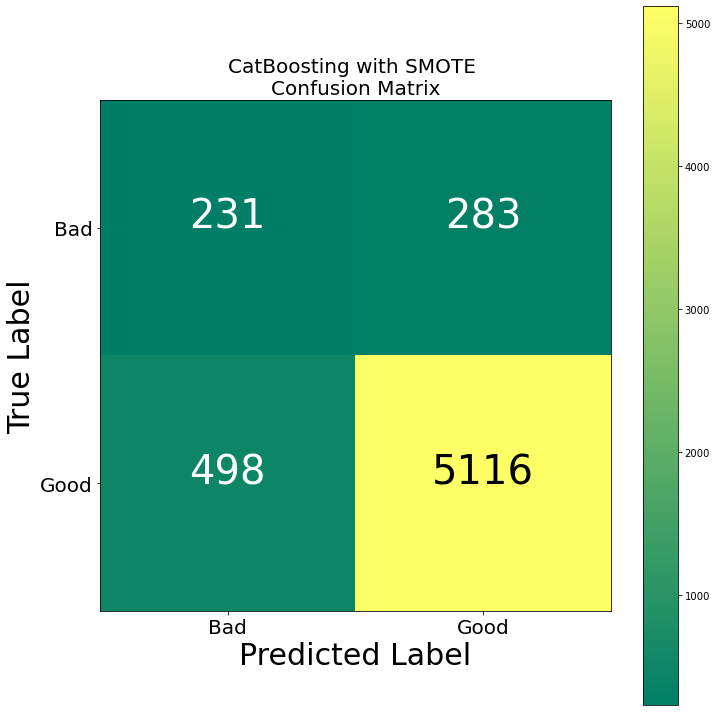

In [56]:
# Print confusion matrix for CatBoost
disp_confusion_matrix(y_pred_sm_catboost, "CatBoosting", "SMOTE")

### 2.6 Comparison of SMOTE Models

In [57]:
comparison_table(y_preds = [y_pred_sm_logreg, y_pred_sm_rf, y_pred_sm_nb, y_pred_sm_xgb, y_pred_sm_catboost], 
                 labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'] )

In [58]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with SMOTE\n')
df_tv2


Comparision Matrix of Modeling with SMOTE



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.858355 bad       0.300676  0.519455  0.380884   
                                  good      0.952863  0.889384  0.920029   
                                  average   0.898159  0.858355  0.874807   
           Random Forest 0.881201 bad       0.207650  0.147860  0.172727   
                                  good      0.923985  0.948343  0.936006   
                                  average   0.863901  0.881201  0.871984   
           Naive Bayes   0.885607 bad       0.379043  0.570039  0.455322   
                                  good      0.958730  0.914499  0.936093   
                                  average   0.910108  0.885607  0.895767   
           XGBoost       0.738251 bad       0.144256  0.429961  0.216031   
                                  good      0.936249  0.766477  0.842899   
                                  average   0.869819  0.738251  0.790319   
           CatBoost      0.872552 bad       0.316872  0.449416  0.371681   
                                  good      0.947583  0.911293  0.929084   
                                  average   0.894681  0.872552  0.882330   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.858355 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.881201 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.885607 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.738251 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.872552 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

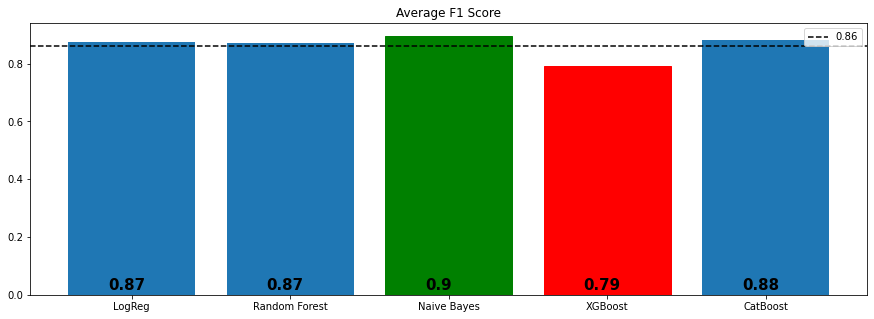

In [59]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 3. Applying PCA to Decrease the Linear Dimensionality + SMOTE

In [60]:
from sklearn.decomposition import PCA
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.975)
pca = PCA(random_state=42)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
pca_X_train = pca.fit_transform(count_vect_train)

count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()
pca_X_test = pca.transform(count_vect_test)

In [61]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
pca_text, pca_target = sm.fit_sample(pca_X_train, y_train)
print (pca_text.shape)
print (pca_target.shape)

(33622, 3274)
(33622,)


In [62]:
Counter(pca_target)

Counter({1: 16811, 0: 16811})

### 3.1 Logistic Regression

In [63]:
# Call the modeling function for logistic regression and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, 
                            random_state = 42), Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_logreg = y_pred

f1 score: 0.900230025355484


**Classification Report**

In [64]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_logreg))

              precision    recall  f1-score   support

           0       0.40      0.63      0.49       514
           1       0.96      0.91      0.94      5614

    accuracy                           0.89      6128
   macro avg       0.68      0.77      0.71      6128
weighted avg       0.92      0.89      0.90      6128



**Confusion Matrix**

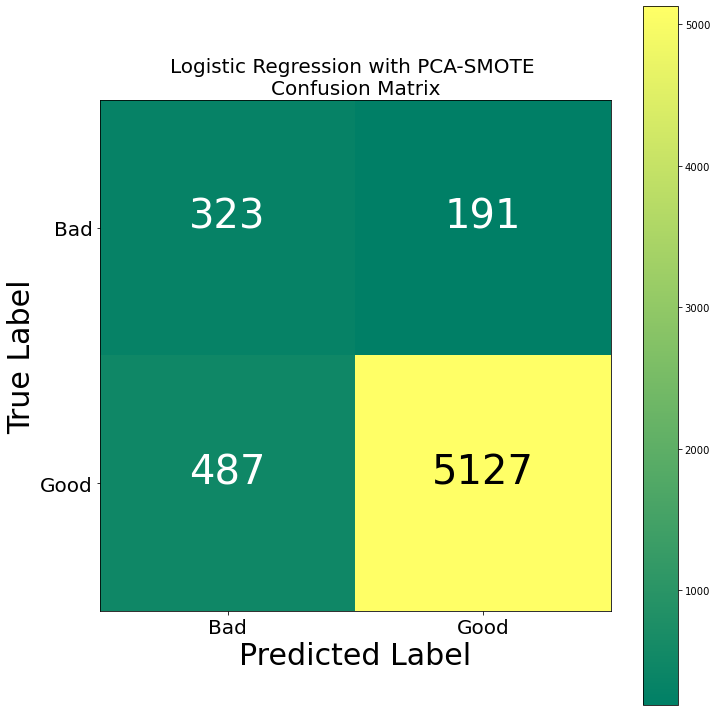

In [65]:
# Print confusion matrix for logistic regression 
disp_confusion_matrix(y_pred_pcasm_logreg, "Logistic Regression", "PCA-SMOTE")

### 3.2 Random Forest

In [66]:
# Call the modeling function for random forest classifier and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_rf = y_pred

f1 score: 0.8758289768472364


**Classification Report**

In [67]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_rf))

              precision    recall  f1-score   support

           0       0.19      0.04      0.06       514
           1       0.92      0.99      0.95      5614

    accuracy                           0.91      6128
   macro avg       0.55      0.51      0.50      6128
weighted avg       0.86      0.91      0.88      6128



**Confusion Matrix**

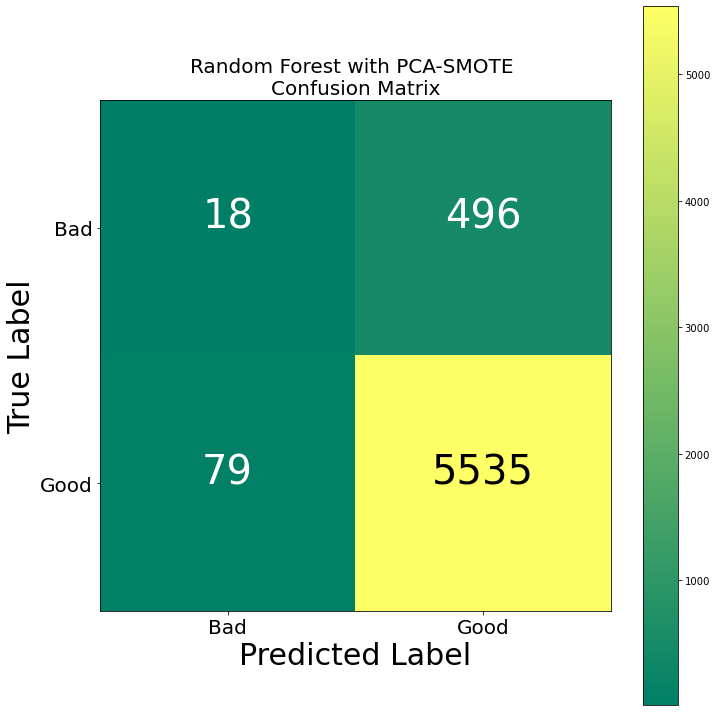

In [68]:
# Print confusion matrix for random forest classifier
disp_confusion_matrix(y_pred_pcasm_rf, "Random Forest", "PCA-SMOTE")

### 3.3 XGBoost

In [69]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_xgb = y_pred

f1 score: 0.8410466100864621


**Classification Report**

In [70]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_xgb))

              precision    recall  f1-score   support

           0       0.19      0.37      0.25       514
           1       0.94      0.86      0.90      5614

    accuracy                           0.82      6128
   macro avg       0.56      0.61      0.57      6128
weighted avg       0.87      0.82      0.84      6128



**Confusion Matrix**

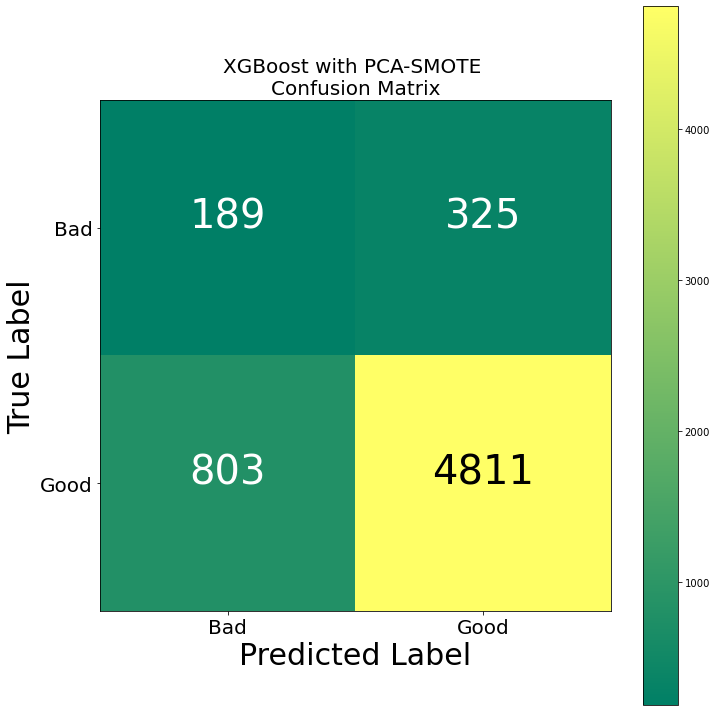

In [71]:
# Print confusion matrix for XGBoost
disp_confusion_matrix(y_pred_pcasm_xgb, "XGBoost", "PCA-SMOTE")

### 3.4 CatBoost

In [72]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_catboost = y_pred

0:	learn: 0.6470906	total: 142ms	remaining: 3m 33s
1:	learn: 0.6218541	total: 272ms	remaining: 3m 23s
2:	learn: 0.6005240	total: 408ms	remaining: 3m 23s
3:	learn: 0.5853862	total: 543ms	remaining: 3m 23s
4:	learn: 0.5729316	total: 675ms	remaining: 3m 21s
5:	learn: 0.5609008	total: 817ms	remaining: 3m 23s
6:	learn: 0.5522953	total: 958ms	remaining: 3m 24s
7:	learn: 0.5438020	total: 1.11s	remaining: 3m 26s
8:	learn: 0.5368297	total: 1.23s	remaining: 3m 24s
9:	learn: 0.5293909	total: 1.36s	remaining: 3m 23s
10:	learn: 0.5229246	total: 1.5s	remaining: 3m 23s
11:	learn: 0.5164628	total: 1.64s	remaining: 3m 22s
12:	learn: 0.5091442	total: 1.76s	remaining: 3m 21s
13:	learn: 0.5033469	total: 1.88s	remaining: 3m 19s
14:	learn: 0.4959385	total: 2.02s	remaining: 3m 19s
15:	learn: 0.4899178	total: 2.16s	remaining: 3m 20s
16:	learn: 0.4841747	total: 2.32s	remaining: 3m 22s
17:	learn: 0.4792403	total: 2.46s	remaining: 3m 22s
18:	learn: 0.4746650	total: 2.62s	remaining: 3m 24s
19:	learn: 0.4699137	to

158:	learn: 0.1928203	total: 22.3s	remaining: 3m 8s
159:	learn: 0.1917596	total: 22.5s	remaining: 3m 8s
160:	learn: 0.1907347	total: 22.6s	remaining: 3m 8s
161:	learn: 0.1897719	total: 22.7s	remaining: 3m 7s
162:	learn: 0.1889348	total: 22.8s	remaining: 3m 7s
163:	learn: 0.1879236	total: 23s	remaining: 3m 7s
164:	learn: 0.1868991	total: 23.2s	remaining: 3m 7s
165:	learn: 0.1860083	total: 23.3s	remaining: 3m 7s
166:	learn: 0.1851089	total: 23.4s	remaining: 3m 6s
167:	learn: 0.1842213	total: 23.6s	remaining: 3m 6s
168:	learn: 0.1834295	total: 23.7s	remaining: 3m 6s
169:	learn: 0.1826013	total: 23.8s	remaining: 3m 6s
170:	learn: 0.1817308	total: 23.9s	remaining: 3m 6s
171:	learn: 0.1809079	total: 24.1s	remaining: 3m 5s
172:	learn: 0.1799601	total: 24.2s	remaining: 3m 5s
173:	learn: 0.1789352	total: 24.3s	remaining: 3m 5s
174:	learn: 0.1780351	total: 24.5s	remaining: 3m 5s
175:	learn: 0.1772105	total: 24.6s	remaining: 3m 5s
176:	learn: 0.1763159	total: 24.8s	remaining: 3m 5s
177:	learn: 0.

316:	learn: 0.0880231	total: 43.7s	remaining: 2m 42s
317:	learn: 0.0876323	total: 43.8s	remaining: 2m 42s
318:	learn: 0.0871326	total: 43.9s	remaining: 2m 42s
319:	learn: 0.0867769	total: 44s	remaining: 2m 42s
320:	learn: 0.0863539	total: 44.2s	remaining: 2m 42s
321:	learn: 0.0859437	total: 44.3s	remaining: 2m 42s
322:	learn: 0.0854911	total: 44.5s	remaining: 2m 42s
323:	learn: 0.0850788	total: 44.6s	remaining: 2m 42s
324:	learn: 0.0846649	total: 44.8s	remaining: 2m 41s
325:	learn: 0.0842595	total: 44.9s	remaining: 2m 41s
326:	learn: 0.0838759	total: 45.1s	remaining: 2m 41s
327:	learn: 0.0835275	total: 45.2s	remaining: 2m 41s
328:	learn: 0.0830514	total: 45.3s	remaining: 2m 41s
329:	learn: 0.0826226	total: 45.4s	remaining: 2m 41s
330:	learn: 0.0822106	total: 45.5s	remaining: 2m 40s
331:	learn: 0.0818280	total: 45.7s	remaining: 2m 40s
332:	learn: 0.0814429	total: 45.8s	remaining: 2m 40s
333:	learn: 0.0809677	total: 45.9s	remaining: 2m 40s
334:	learn: 0.0805646	total: 46.1s	remaining: 2m

472:	learn: 0.0416275	total: 1m 6s	remaining: 2m 24s
473:	learn: 0.0414567	total: 1m 6s	remaining: 2m 23s
474:	learn: 0.0412704	total: 1m 6s	remaining: 2m 23s
475:	learn: 0.0411566	total: 1m 6s	remaining: 2m 23s
476:	learn: 0.0410108	total: 1m 6s	remaining: 2m 23s
477:	learn: 0.0408311	total: 1m 6s	remaining: 2m 23s
478:	learn: 0.0406230	total: 1m 7s	remaining: 2m 23s
479:	learn: 0.0403988	total: 1m 7s	remaining: 2m 22s
480:	learn: 0.0402097	total: 1m 7s	remaining: 2m 22s
481:	learn: 0.0400169	total: 1m 7s	remaining: 2m 22s
482:	learn: 0.0398410	total: 1m 7s	remaining: 2m 22s
483:	learn: 0.0396457	total: 1m 7s	remaining: 2m 22s
484:	learn: 0.0394186	total: 1m 7s	remaining: 2m 22s
485:	learn: 0.0392232	total: 1m 8s	remaining: 2m 21s
486:	learn: 0.0390145	total: 1m 8s	remaining: 2m 21s
487:	learn: 0.0388369	total: 1m 8s	remaining: 2m 21s
488:	learn: 0.0386564	total: 1m 8s	remaining: 2m 21s
489:	learn: 0.0384557	total: 1m 8s	remaining: 2m 21s
490:	learn: 0.0382672	total: 1m 8s	remaining: 

626:	learn: 0.0204879	total: 1m 27s	remaining: 2m 2s
627:	learn: 0.0203527	total: 1m 27s	remaining: 2m 1s
628:	learn: 0.0202550	total: 1m 27s	remaining: 2m 1s
629:	learn: 0.0201539	total: 1m 28s	remaining: 2m 1s
630:	learn: 0.0201004	total: 1m 28s	remaining: 2m 1s
631:	learn: 0.0200499	total: 1m 28s	remaining: 2m 1s
632:	learn: 0.0199670	total: 1m 28s	remaining: 2m 1s
633:	learn: 0.0198665	total: 1m 28s	remaining: 2m 1s
634:	learn: 0.0197893	total: 1m 28s	remaining: 2m
635:	learn: 0.0196856	total: 1m 28s	remaining: 2m
636:	learn: 0.0196261	total: 1m 29s	remaining: 2m
637:	learn: 0.0195433	total: 1m 29s	remaining: 2m
638:	learn: 0.0194551	total: 1m 29s	remaining: 2m
639:	learn: 0.0193695	total: 1m 29s	remaining: 2m
640:	learn: 0.0192960	total: 1m 29s	remaining: 2m
641:	learn: 0.0192018	total: 1m 29s	remaining: 1m 59s
642:	learn: 0.0191169	total: 1m 29s	remaining: 1m 59s
643:	learn: 0.0190311	total: 1m 30s	remaining: 1m 59s
644:	learn: 0.0189552	total: 1m 30s	remaining: 1m 59s
645:	learn

779:	learn: 0.0107107	total: 1m 48s	remaining: 1m 40s
780:	learn: 0.0106628	total: 1m 49s	remaining: 1m 40s
781:	learn: 0.0106115	total: 1m 49s	remaining: 1m 40s
782:	learn: 0.0105686	total: 1m 49s	remaining: 1m 40s
783:	learn: 0.0105323	total: 1m 49s	remaining: 1m 39s
784:	learn: 0.0104796	total: 1m 49s	remaining: 1m 39s
785:	learn: 0.0104297	total: 1m 49s	remaining: 1m 39s
786:	learn: 0.0103845	total: 1m 49s	remaining: 1m 39s
787:	learn: 0.0103445	total: 1m 49s	remaining: 1m 39s
788:	learn: 0.0103011	total: 1m 50s	remaining: 1m 39s
789:	learn: 0.0102534	total: 1m 50s	remaining: 1m 38s
790:	learn: 0.0102040	total: 1m 50s	remaining: 1m 38s
791:	learn: 0.0102039	total: 1m 50s	remaining: 1m 38s
792:	learn: 0.0101561	total: 1m 50s	remaining: 1m 38s
793:	learn: 0.0101107	total: 1m 50s	remaining: 1m 38s
794:	learn: 0.0101097	total: 1m 50s	remaining: 1m 38s
795:	learn: 0.0100682	total: 1m 51s	remaining: 1m 38s
796:	learn: 0.0100215	total: 1m 51s	remaining: 1m 38s
797:	learn: 0.0099710	total:

933:	learn: 0.0078880	total: 2m 10s	remaining: 1m 18s
934:	learn: 0.0078879	total: 2m 10s	remaining: 1m 18s
935:	learn: 0.0078872	total: 2m 10s	remaining: 1m 18s
936:	learn: 0.0078870	total: 2m 10s	remaining: 1m 18s
937:	learn: 0.0078855	total: 2m 10s	remaining: 1m 18s
938:	learn: 0.0078848	total: 2m 10s	remaining: 1m 18s
939:	learn: 0.0078846	total: 2m 10s	remaining: 1m 18s
940:	learn: 0.0078839	total: 2m 11s	remaining: 1m 17s
941:	learn: 0.0078431	total: 2m 11s	remaining: 1m 17s
942:	learn: 0.0078162	total: 2m 11s	remaining: 1m 17s
943:	learn: 0.0078159	total: 2m 11s	remaining: 1m 17s
944:	learn: 0.0078150	total: 2m 11s	remaining: 1m 17s
945:	learn: 0.0078149	total: 2m 11s	remaining: 1m 17s
946:	learn: 0.0078142	total: 2m 11s	remaining: 1m 17s
947:	learn: 0.0078140	total: 2m 12s	remaining: 1m 16s
948:	learn: 0.0078139	total: 2m 12s	remaining: 1m 16s
949:	learn: 0.0078126	total: 2m 12s	remaining: 1m 16s
950:	learn: 0.0078124	total: 2m 12s	remaining: 1m 16s
951:	learn: 0.0078123	total:

1087:	learn: 0.0069786	total: 2m 32s	remaining: 57.7s
1088:	learn: 0.0069780	total: 2m 32s	remaining: 57.6s
1089:	learn: 0.0069773	total: 2m 32s	remaining: 57.4s
1090:	learn: 0.0069773	total: 2m 32s	remaining: 57.3s
1091:	learn: 0.0069766	total: 2m 33s	remaining: 57.2s
1092:	learn: 0.0069766	total: 2m 33s	remaining: 57s
1093:	learn: 0.0069764	total: 2m 33s	remaining: 56.9s
1094:	learn: 0.0069764	total: 2m 33s	remaining: 56.8s
1095:	learn: 0.0069764	total: 2m 33s	remaining: 56.6s
1096:	learn: 0.0069763	total: 2m 33s	remaining: 56.5s
1097:	learn: 0.0069763	total: 2m 33s	remaining: 56.3s
1098:	learn: 0.0069763	total: 2m 34s	remaining: 56.2s
1099:	learn: 0.0069762	total: 2m 34s	remaining: 56.1s
1100:	learn: 0.0069762	total: 2m 34s	remaining: 55.9s
1101:	learn: 0.0069759	total: 2m 34s	remaining: 55.8s
1102:	learn: 0.0069759	total: 2m 34s	remaining: 55.7s
1103:	learn: 0.0069754	total: 2m 34s	remaining: 55.5s
1104:	learn: 0.0069753	total: 2m 34s	remaining: 55.4s
1105:	learn: 0.0069517	total: 

1241:	learn: 0.0066626	total: 2m 54s	remaining: 36.3s
1242:	learn: 0.0066625	total: 2m 54s	remaining: 36.1s
1243:	learn: 0.0066624	total: 2m 54s	remaining: 36s
1244:	learn: 0.0066620	total: 2m 54s	remaining: 35.8s
1245:	learn: 0.0066619	total: 2m 55s	remaining: 35.7s
1246:	learn: 0.0066619	total: 2m 55s	remaining: 35.6s
1247:	learn: 0.0066618	total: 2m 55s	remaining: 35.4s
1248:	learn: 0.0066613	total: 2m 55s	remaining: 35.3s
1249:	learn: 0.0066613	total: 2m 55s	remaining: 35.1s
1250:	learn: 0.0066612	total: 2m 55s	remaining: 35s
1251:	learn: 0.0066610	total: 2m 55s	remaining: 34.8s
1252:	learn: 0.0066610	total: 2m 56s	remaining: 34.7s
1253:	learn: 0.0066609	total: 2m 56s	remaining: 34.6s
1254:	learn: 0.0066606	total: 2m 56s	remaining: 34.4s
1255:	learn: 0.0066605	total: 2m 56s	remaining: 34.3s
1256:	learn: 0.0066600	total: 2m 56s	remaining: 34.1s
1257:	learn: 0.0066599	total: 2m 56s	remaining: 34s
1258:	learn: 0.0066594	total: 2m 56s	remaining: 33.8s
1259:	learn: 0.0066589	total: 2m 5

1397:	learn: 0.0064444	total: 3m 15s	remaining: 14.3s
1398:	learn: 0.0064444	total: 3m 15s	remaining: 14.1s
1399:	learn: 0.0064444	total: 3m 15s	remaining: 14s
1400:	learn: 0.0064444	total: 3m 15s	remaining: 13.8s
1401:	learn: 0.0064441	total: 3m 16s	remaining: 13.7s
1402:	learn: 0.0064441	total: 3m 16s	remaining: 13.6s
1403:	learn: 0.0064437	total: 3m 16s	remaining: 13.4s
1404:	learn: 0.0064435	total: 3m 16s	remaining: 13.3s
1405:	learn: 0.0064432	total: 3m 16s	remaining: 13.1s
1406:	learn: 0.0064151	total: 3m 16s	remaining: 13s
1407:	learn: 0.0064149	total: 3m 16s	remaining: 12.9s
1408:	learn: 0.0064149	total: 3m 17s	remaining: 12.7s
1409:	learn: 0.0063808	total: 3m 17s	remaining: 12.6s
1410:	learn: 0.0063805	total: 3m 17s	remaining: 12.4s
1411:	learn: 0.0063805	total: 3m 17s	remaining: 12.3s
1412:	learn: 0.0063805	total: 3m 17s	remaining: 12.2s
1413:	learn: 0.0063804	total: 3m 17s	remaining: 12s
1414:	learn: 0.0063804	total: 3m 17s	remaining: 11.9s
1415:	learn: 0.0063804	total: 3m 1

**Classification Report**

In [73]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_catboost))

              precision    recall  f1-score   support

           0       0.39      0.28      0.33       514
           1       0.94      0.96      0.95      5614

    accuracy                           0.90      6128
   macro avg       0.66      0.62      0.64      6128
weighted avg       0.89      0.90      0.90      6128



**Confusion Matrix**

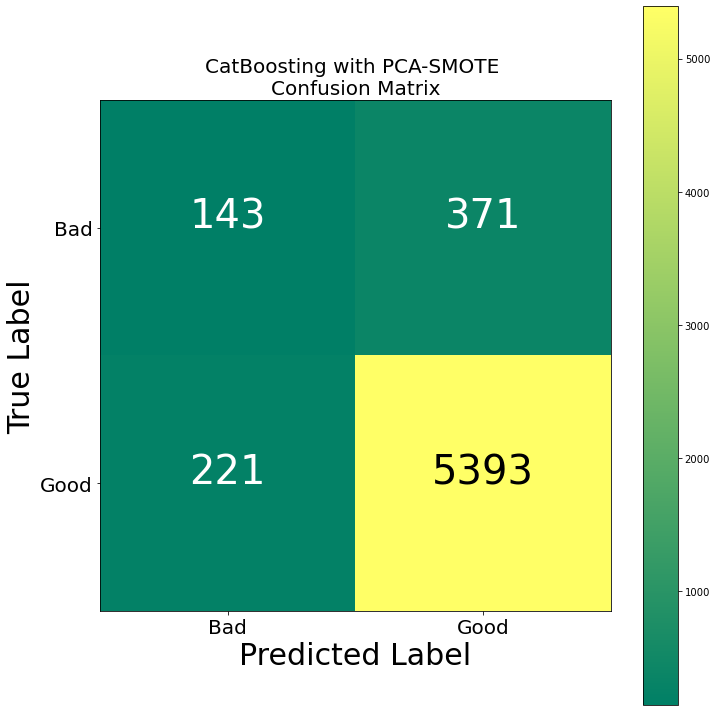

In [74]:
# Print confusion matrix for CatBoost 
disp_confusion_matrix(y_pred_pcasm_catboost, "CatBoosting", "PCA-SMOTE")

### 3.5 Comparison of PCA-SMOTE Models

In [75]:
comparison_table(y_preds = [y_pred_pcasm_logreg, y_pred_pcasm_rf, y_pred_pcasm_xgb, y_pred_pcasm_catboost], 
                 labels = ['LogReg', 'Random Forest', 'XGBoost', 'CatBoost'])

In [76]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with PCA & SMOTE\n')
df_tv2


Comparision Matrix of Modeling with PCA & SMOTE



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.889360 bad       0.398765  0.628405  0.487915   
                                  good      0.964084  0.913253  0.937980   
                                  average   0.916667  0.889360  0.900230   
           Random Forest 0.906168 bad       0.185567  0.035019  0.058920   
                                  good      0.917758  0.985928  0.950623   
                                  average   0.856344  0.906168  0.875829   
           XGBoost       0.815927 bad       0.190524  0.367704  0.250996   
                                  good      0.936721  0.856965  0.895070   
                                  average   0.874132  0.815927  0.841047   
           CatBoost      0.903394 bad       0.392857  0.278210  0.325740   
                                  good      0.935635  0.960634  0.947970   
                                  average   0.890108  0.903394  0.895779   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.889360 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.906168 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.815927 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.903394 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

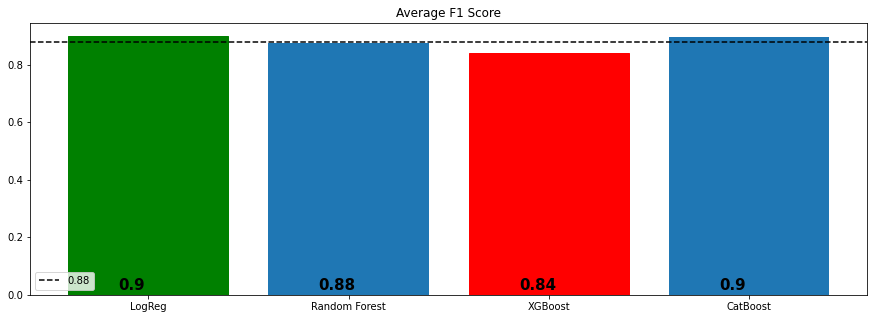

In [77]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 4. Truncated SVD + SMOTE

In [78]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(random_state=42)
svd_X_train = svd.fit_transform(count_vect_train)
svd_X_test = svd.transform(count_vect_test)

### SMOTE

In [79]:
sm = SMOTE(random_state=5)
df_ttext, df_ttarget = sm.fit_sample(svd_X_train, y_train)

print (df_ttext.shape)
print (df_ttarget.shape)

(33622, 2)
(33622,)


In [80]:
from collections import Counter
Counter(df_ttarget)

Counter({1: 16811, 0: 16811})

### 4.1 Logistic Regression

In [81]:
# Call the modeling function for logistic regression and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, 
                            random_state = 42), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_logreg = y_pred

f1 score: 0.7454992645846952


**Classification Report**


In [82]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_logreg))

              precision    recall  f1-score   support

           0       0.11      0.42      0.18       514
           1       0.93      0.70      0.80      5614

    accuracy                           0.67      6128
   macro avg       0.52      0.56      0.49      6128
weighted avg       0.86      0.67      0.75      6128



**Confusion Matrix**

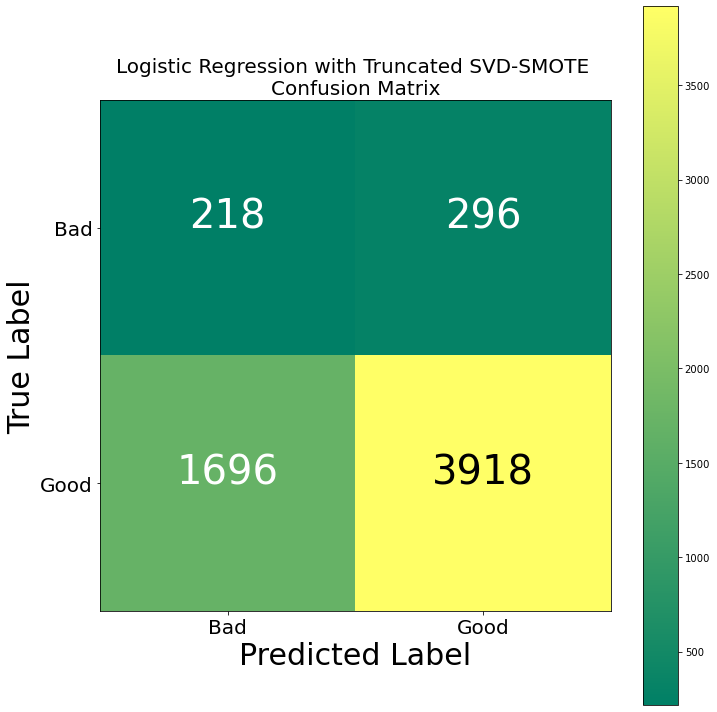

In [83]:
# Print confusion matrix for logistic regression 
disp_confusion_matrix(y_pred_svd_logreg, "Logistic Regression", "Truncated SVD-SMOTE")

### 4.2 Random Forest

In [84]:
# Call the modeling function for random forest classifier and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_rf = y_pred

f1 score: 0.7617224211268312


**Classification Report**

In [85]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_rf))

              precision    recall  f1-score   support

           0       0.09      0.30      0.14       514
           1       0.92      0.74      0.82      5614

    accuracy                           0.70      6128
   macro avg       0.51      0.52      0.48      6128
weighted avg       0.85      0.70      0.76      6128



**Confusion Matrix**

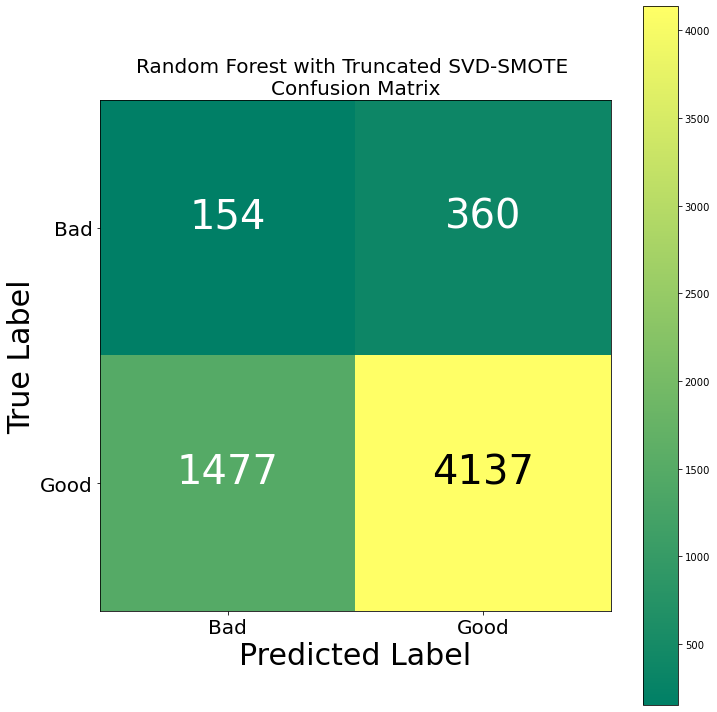

In [86]:
# Print confusion matrix for random forest classifier
disp_confusion_matrix(y_pred_svd_rf, "Random Forest", "Truncated SVD-SMOTE")

### 4.3 XGBoost

In [87]:
# Call the modeling function for XGBoost and print f1 score
modeling(XGBClassifier(), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_xgb = y_pred

f1 score: 0.6217438680059355


**Classification Report**

In [88]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_xgb))

              precision    recall  f1-score   support

           0       0.11      0.65      0.19       514
           1       0.94      0.51      0.66      5614

    accuracy                           0.52      6128
   macro avg       0.53      0.58      0.42      6128
weighted avg       0.87      0.52      0.62      6128



**Confusion Matrix**

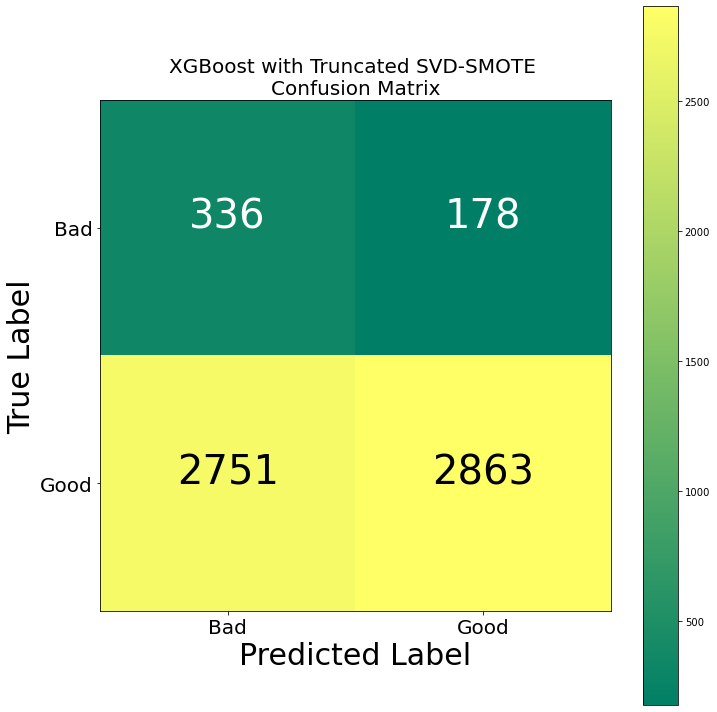

In [89]:
# Print confusion matrix for XGBoost
disp_confusion_matrix(y_pred_svd_xgb, "XGBoost", "Truncated SVD-SMOTE")

### 4.4 CatBoost

In [90]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_catboost = y_pred

0:	learn: 0.6869855	total: 5.19ms	remaining: 7.78s
1:	learn: 0.6832453	total: 12.6ms	remaining: 9.43s
2:	learn: 0.6797396	total: 19.8ms	remaining: 9.88s
3:	learn: 0.6780442	total: 25.9ms	remaining: 9.68s
4:	learn: 0.6769251	total: 31.7ms	remaining: 9.47s
5:	learn: 0.6762835	total: 39.1ms	remaining: 9.75s
6:	learn: 0.6754514	total: 44.6ms	remaining: 9.52s
7:	learn: 0.6746966	total: 50.1ms	remaining: 9.34s
8:	learn: 0.6727680	total: 56.1ms	remaining: 9.3s
9:	learn: 0.6718932	total: 61.3ms	remaining: 9.13s
10:	learn: 0.6712514	total: 66.5ms	remaining: 9.01s
11:	learn: 0.6708247	total: 73.8ms	remaining: 9.15s
12:	learn: 0.6702815	total: 79.5ms	remaining: 9.1s
13:	learn: 0.6696887	total: 84.8ms	remaining: 9s
14:	learn: 0.6690606	total: 91ms	remaining: 9.01s
15:	learn: 0.6688078	total: 98ms	remaining: 9.09s
16:	learn: 0.6677630	total: 104ms	remaining: 9.04s
17:	learn: 0.6673907	total: 109ms	remaining: 8.96s
18:	learn: 0.6671270	total: 116ms	remaining: 9.07s
19:	learn: 0.6666067	total: 122ms	

163:	learn: 0.6404692	total: 1.1s	remaining: 8.96s
164:	learn: 0.6403541	total: 1.11s	remaining: 8.96s
165:	learn: 0.6402645	total: 1.11s	remaining: 8.95s
166:	learn: 0.6401953	total: 1.12s	remaining: 8.95s
167:	learn: 0.6401104	total: 1.13s	remaining: 8.93s
168:	learn: 0.6399053	total: 1.13s	remaining: 8.93s
169:	learn: 0.6398141	total: 1.14s	remaining: 8.94s
170:	learn: 0.6397510	total: 1.15s	remaining: 8.93s
171:	learn: 0.6397262	total: 1.16s	remaining: 8.92s
172:	learn: 0.6396639	total: 1.16s	remaining: 8.91s
173:	learn: 0.6396427	total: 1.17s	remaining: 8.91s
174:	learn: 0.6396280	total: 1.18s	remaining: 8.9s
175:	learn: 0.6395459	total: 1.18s	remaining: 8.9s
176:	learn: 0.6394965	total: 1.19s	remaining: 8.89s
177:	learn: 0.6393979	total: 1.2s	remaining: 8.88s
178:	learn: 0.6393393	total: 1.2s	remaining: 8.87s
179:	learn: 0.6392422	total: 1.21s	remaining: 8.87s
180:	learn: 0.6391748	total: 1.22s	remaining: 8.87s
181:	learn: 0.6391600	total: 1.22s	remaining: 8.87s
182:	learn: 0.639

323:	learn: 0.6285162	total: 2.21s	remaining: 8.01s
324:	learn: 0.6285081	total: 2.21s	remaining: 8s
325:	learn: 0.6284858	total: 2.22s	remaining: 8s
326:	learn: 0.6284136	total: 2.23s	remaining: 7.99s
327:	learn: 0.6283955	total: 2.23s	remaining: 7.98s
328:	learn: 0.6283772	total: 2.24s	remaining: 7.98s
329:	learn: 0.6283396	total: 2.25s	remaining: 7.97s
330:	learn: 0.6282979	total: 2.26s	remaining: 7.97s
331:	learn: 0.6282516	total: 2.26s	remaining: 7.96s
332:	learn: 0.6282356	total: 2.27s	remaining: 7.95s
333:	learn: 0.6281525	total: 2.28s	remaining: 7.95s
334:	learn: 0.6281503	total: 2.28s	remaining: 7.94s
335:	learn: 0.6281219	total: 2.29s	remaining: 7.93s
336:	learn: 0.6280981	total: 2.3s	remaining: 7.93s
337:	learn: 0.6280940	total: 2.3s	remaining: 7.92s
338:	learn: 0.6279928	total: 2.31s	remaining: 7.91s
339:	learn: 0.6279374	total: 2.32s	remaining: 7.9s
340:	learn: 0.6278910	total: 2.32s	remaining: 7.9s
341:	learn: 0.6278850	total: 2.33s	remaining: 7.89s
342:	learn: 0.6278057	

482:	learn: 0.6201224	total: 3.29s	remaining: 6.93s
483:	learn: 0.6200523	total: 3.3s	remaining: 6.93s
484:	learn: 0.6200361	total: 3.31s	remaining: 6.92s
485:	learn: 0.6200158	total: 3.31s	remaining: 6.91s
486:	learn: 0.6199882	total: 3.32s	remaining: 6.9s
487:	learn: 0.6199702	total: 3.32s	remaining: 6.89s
488:	learn: 0.6199535	total: 3.33s	remaining: 6.89s
489:	learn: 0.6199156	total: 3.34s	remaining: 6.88s
490:	learn: 0.6198676	total: 3.34s	remaining: 6.87s
491:	learn: 0.6198452	total: 3.35s	remaining: 6.87s
492:	learn: 0.6198144	total: 3.36s	remaining: 6.86s
493:	learn: 0.6197867	total: 3.36s	remaining: 6.85s
494:	learn: 0.6197686	total: 3.37s	remaining: 6.84s
495:	learn: 0.6197473	total: 3.38s	remaining: 6.83s
496:	learn: 0.6197027	total: 3.38s	remaining: 6.83s
497:	learn: 0.6196870	total: 3.39s	remaining: 6.82s
498:	learn: 0.6196254	total: 3.4s	remaining: 6.82s
499:	learn: 0.6195983	total: 3.4s	remaining: 6.81s
500:	learn: 0.6195745	total: 3.41s	remaining: 6.8s
501:	learn: 0.619

660:	learn: 0.6128057	total: 4.59s	remaining: 5.82s
661:	learn: 0.6127857	total: 4.59s	remaining: 5.81s
662:	learn: 0.6127814	total: 4.6s	remaining: 5.81s
663:	learn: 0.6127031	total: 4.61s	remaining: 5.8s
664:	learn: 0.6126097	total: 4.62s	remaining: 5.8s
665:	learn: 0.6125838	total: 4.63s	remaining: 5.79s
666:	learn: 0.6125657	total: 4.63s	remaining: 5.78s
667:	learn: 0.6125265	total: 4.64s	remaining: 5.78s
668:	learn: 0.6125032	total: 4.65s	remaining: 5.77s
669:	learn: 0.6124734	total: 4.66s	remaining: 5.77s
670:	learn: 0.6124535	total: 4.66s	remaining: 5.76s
671:	learn: 0.6124094	total: 4.67s	remaining: 5.75s
672:	learn: 0.6123916	total: 4.68s	remaining: 5.75s
673:	learn: 0.6123915	total: 4.68s	remaining: 5.74s
674:	learn: 0.6123720	total: 4.69s	remaining: 5.73s
675:	learn: 0.6123356	total: 4.7s	remaining: 5.73s
676:	learn: 0.6123288	total: 4.71s	remaining: 5.72s
677:	learn: 0.6123261	total: 4.71s	remaining: 5.71s
678:	learn: 0.6122744	total: 4.72s	remaining: 5.71s
679:	learn: 0.61

840:	learn: 0.6076541	total: 6.04s	remaining: 4.73s
841:	learn: 0.6076411	total: 6.04s	remaining: 4.72s
842:	learn: 0.6075896	total: 6.05s	remaining: 4.72s
843:	learn: 0.6075417	total: 6.06s	remaining: 4.71s
844:	learn: 0.6074925	total: 6.07s	remaining: 4.7s
845:	learn: 0.6074714	total: 6.07s	remaining: 4.69s
846:	learn: 0.6074221	total: 6.08s	remaining: 4.69s
847:	learn: 0.6074148	total: 6.09s	remaining: 4.68s
848:	learn: 0.6073705	total: 6.09s	remaining: 4.67s
849:	learn: 0.6073524	total: 6.1s	remaining: 4.67s
850:	learn: 0.6073269	total: 6.11s	remaining: 4.66s
851:	learn: 0.6073129	total: 6.11s	remaining: 4.65s
852:	learn: 0.6072653	total: 6.12s	remaining: 4.64s
853:	learn: 0.6072577	total: 6.13s	remaining: 4.63s
854:	learn: 0.6072054	total: 6.13s	remaining: 4.63s
855:	learn: 0.6071748	total: 6.14s	remaining: 4.62s
856:	learn: 0.6071342	total: 6.15s	remaining: 4.61s
857:	learn: 0.6071236	total: 6.16s	remaining: 4.61s
858:	learn: 0.6070960	total: 6.16s	remaining: 4.6s
859:	learn: 0.6

1022:	learn: 0.6029571	total: 7.3s	remaining: 3.41s
1023:	learn: 0.6029359	total: 7.31s	remaining: 3.4s
1024:	learn: 0.6028664	total: 7.32s	remaining: 3.39s
1025:	learn: 0.6028459	total: 7.33s	remaining: 3.38s
1026:	learn: 0.6028399	total: 7.33s	remaining: 3.38s
1027:	learn: 0.6028292	total: 7.34s	remaining: 3.37s
1028:	learn: 0.6028055	total: 7.35s	remaining: 3.36s
1029:	learn: 0.6028023	total: 7.35s	remaining: 3.35s
1030:	learn: 0.6027851	total: 7.36s	remaining: 3.35s
1031:	learn: 0.6027616	total: 7.37s	remaining: 3.34s
1032:	learn: 0.6027481	total: 7.37s	remaining: 3.33s
1033:	learn: 0.6027480	total: 7.38s	remaining: 3.33s
1034:	learn: 0.6027241	total: 7.38s	remaining: 3.32s
1035:	learn: 0.6027239	total: 7.39s	remaining: 3.31s
1036:	learn: 0.6026969	total: 7.4s	remaining: 3.3s
1037:	learn: 0.6026592	total: 7.41s	remaining: 3.3s
1038:	learn: 0.6026298	total: 7.41s	remaining: 3.29s
1039:	learn: 0.6025964	total: 7.42s	remaining: 3.28s
1040:	learn: 0.6025688	total: 7.43s	remaining: 3.27

1191:	learn: 0.5995276	total: 8.4s	remaining: 2.17s
1192:	learn: 0.5995202	total: 8.4s	remaining: 2.16s
1193:	learn: 0.5995104	total: 8.41s	remaining: 2.15s
1194:	learn: 0.5994851	total: 8.42s	remaining: 2.15s
1195:	learn: 0.5994798	total: 8.42s	remaining: 2.14s
1196:	learn: 0.5994761	total: 8.43s	remaining: 2.13s
1197:	learn: 0.5994407	total: 8.44s	remaining: 2.13s
1198:	learn: 0.5994276	total: 8.44s	remaining: 2.12s
1199:	learn: 0.5994196	total: 8.45s	remaining: 2.11s
1200:	learn: 0.5993728	total: 8.46s	remaining: 2.1s
1201:	learn: 0.5993257	total: 8.46s	remaining: 2.1s
1202:	learn: 0.5993096	total: 8.47s	remaining: 2.09s
1203:	learn: 0.5993091	total: 8.47s	remaining: 2.08s
1204:	learn: 0.5992841	total: 8.48s	remaining: 2.08s
1205:	learn: 0.5992652	total: 8.49s	remaining: 2.07s
1206:	learn: 0.5992531	total: 8.49s	remaining: 2.06s
1207:	learn: 0.5992361	total: 8.5s	remaining: 2.05s
1208:	learn: 0.5992360	total: 8.51s	remaining: 2.05s
1209:	learn: 0.5992068	total: 8.51s	remaining: 2.04

1370:	learn: 0.5959815	total: 9.68s	remaining: 910ms
1371:	learn: 0.5959559	total: 9.68s	remaining: 903ms
1372:	learn: 0.5959414	total: 9.69s	remaining: 896ms
1373:	learn: 0.5959375	total: 9.69s	remaining: 889ms
1374:	learn: 0.5959315	total: 9.7s	remaining: 882ms
1375:	learn: 0.5959043	total: 9.71s	remaining: 875ms
1376:	learn: 0.5958712	total: 9.71s	remaining: 868ms
1377:	learn: 0.5958583	total: 9.72s	remaining: 860ms
1378:	learn: 0.5958353	total: 9.72s	remaining: 853ms
1379:	learn: 0.5958266	total: 9.73s	remaining: 846ms
1380:	learn: 0.5958101	total: 9.73s	remaining: 839ms
1381:	learn: 0.5957811	total: 9.74s	remaining: 832ms
1382:	learn: 0.5957641	total: 9.75s	remaining: 825ms
1383:	learn: 0.5957389	total: 9.75s	remaining: 818ms
1384:	learn: 0.5957386	total: 9.76s	remaining: 811ms
1385:	learn: 0.5957177	total: 9.77s	remaining: 804ms
1386:	learn: 0.5956813	total: 9.78s	remaining: 797ms
1387:	learn: 0.5956554	total: 9.78s	remaining: 789ms
1388:	learn: 0.5956552	total: 9.79s	remaining: 

**Classification Report**

In [91]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_catboost))

              precision    recall  f1-score   support

           0       0.10      0.50      0.17       514
           1       0.93      0.60      0.73      5614

    accuracy                           0.59      6128
   macro avg       0.52      0.55      0.45      6128
weighted avg       0.86      0.59      0.68      6128



**Confusion Matrix**

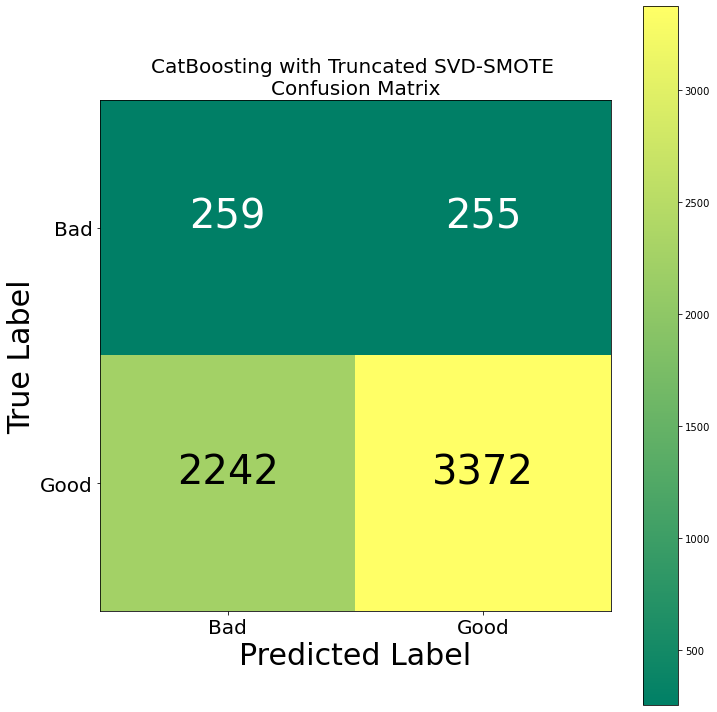

In [92]:
# Print confusion matrix for CatBoost 
disp_confusion_matrix(y_pred_svd_catboost, "CatBoosting", "Truncated SVD-SMOTE")

### 4.5 Comparison of Models

In [93]:
comparison_table(y_preds = [y_pred_svd_logreg, y_pred_svd_rf, y_pred_svd_xgb, y_pred_svd_catboost], 
                 labels = ['LogReg', 'Random Forest', 'XGBoost', 'CatBoost'])

In [94]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with SMOTE\n')
df_tv2


Comparision Matrix of Modeling with SMOTE



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.674935 bad       0.113898  0.424125  0.179572   
                                  good      0.929758  0.697898  0.797314   
                                  average   0.861326  0.674935  0.745499   
           Random Forest 0.700228 bad       0.094421  0.299611  0.143590   
                                  good      0.919947  0.736908  0.818317   
                                  average   0.850704  0.700228  0.761722   
           XGBoost       0.522030 bad       0.108844  0.653696  0.186615   
                                  good      0.941467  0.509975  0.661583   
                                  average   0.871628  0.522030  0.621744   
           CatBoost      0.592526 bad       0.103559  0.503891  0.171808   
                                  good      0.929694  0.600641  0.729791   
                                  average   0.860400  0.592526  0.682989   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.674935 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.700228 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.522030 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.592526 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

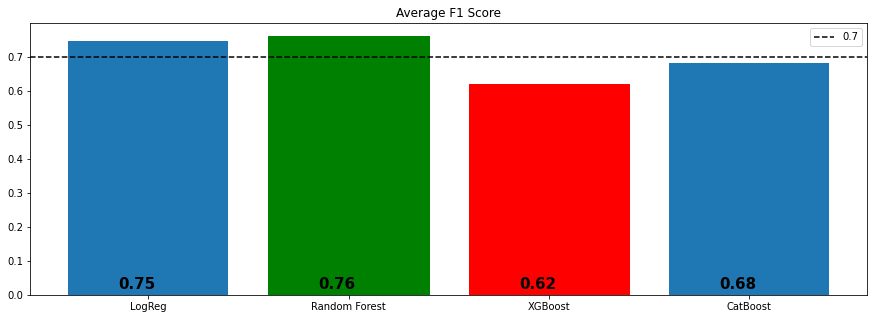

In [95]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")